## The below script prepares the raw data into a prepared set that is ready for Machine Learning

### Outline of notebook:

#### 1.1 Formatting notebook environment and importing dataset
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>CSV_Reader()</u><br>
#### 1.2 Exploratory data analysis
#### 1.3 Data Cleaning/Renaming
&nbsp;&nbsp;&nbsp;&nbsp;3.A Unaltered columns<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.B Dropped columns
#### 1.4 Feature Engineering
&nbsp;&nbsp;&nbsp;&nbsp;4.A Readmitted *(i.e. outcome column)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.B Medication columns<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.C Diagnostic Recoding<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Convert_Disease_Codes()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Replace_Diagnosis_Injury()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Replace_Residual_Diagnosis()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;4.D Binned Columns<br>
#### 1.5 Dumifying categorical variables
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Replace_With_Dummies()</u><br>
#### 1.6 Exporting engineered datasets to S3
&nbsp;&nbsp;&nbsp;&nbsp;Train/validation and test data subsets saved in csv<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Export_Processed_CSV()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Train/validation data susbet saved in protobuf<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Export_Processed_Protobuf()</u><br>

## 1.1 Formatting notebook environment and importing dataset

#### We begin by importing the necessary libraries.

In [1]:
#Data manipulation libraries
import pandas as pd
import numpy as np
import random as random
from sklearn.utils import shuffle

#Data visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt

#Sagemaker and other AWS libraries
import sagemaker
import sagemaker.amazon.common as smac
import boto3
import io
from io import StringIO
from sagemaker import get_execution_role
import os

#Defining some variables for Sagemaker session
region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


#### As this is a fairly large dataset (especially once it has been dummified) we will reformat the default display dimensions to reflect this.

In [2]:
#500 rows and columns will be presented
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

#### The below function will read in our dataset.

In [3]:
def CSV_Reader(bucket, subfolder, source_file_name):
    
    '''The CSV_Reader() function takes in the names of the bucket, subfolder, and source file name, and desired dataframe name. 
    It first constructs the filepath, and then imports the file residing at this filepath, based on the title fed to the function.
    
    Arguments 
    --------- 
    bucket: Head S3 repository bucket
    subfolder: Subfolder containing the source data
    source_file_name: Name of source CSV data file 
    
    Return
    ---------
    Returns the source data in a pandas dataframe '''
    
    data_location = 's3://{}/{}/{}'.format(bucket, subfolder, source_file_name)  
    dataset = pd.read_csv(data_location, low_memory=False)
    return dataset

#### Establishing directory and file names

In [4]:
bucket = 'diabetes-directory'
data_input_folder = 'input'
input_file_name = 'Diabetes_Input.csv'
processed_data_folder = 'diabetes_processed_data'

#### Reading in the data from S3

In [5]:
diabetes = CSV_Reader(bucket, data_input_folder, input_file_name)

## 1.2 Exploratory data analysis

#### We will start with performing preliminary exploratory data analysis. In the below cell we will cycle through each column within the dataset, and perform:
1. A value count to display the variable's spread<br>
2. A basic descriptive analysis<br>
3. A count of missing values<br>
4. A histogram to display the variable's spread visually

#### The below function loops sequentially through each variable/column within the dataset, to provide our initial exploratory analysis.

In [6]:
def Exploratory_Data_Analysis(data_frame, column_list):
    
    '''The Exploratory_Data_Analysis() function sequentially cycles through each column within the dataset, and 
    produces an initial descriptive/exploratory analysis of the entire dataset.
    
    Arguments 
    --------- 
    data_frame: The name of the dataset
    column_list: A list containing each column name for the dataset
    
    Return
    ---------
    Returns the following analysis for each column/variable in the dataset:
    1. A value count
    2. A descriptive statsical analysis
    3. The number of NAs in the column
    4. A histogram of the column'''
    
    for column in data_frame[column_list]:
        
        print("---- Input Variable: %s ---" %column,'\n')
    #Display a value count
        print("1. Value count for the %s variable:" %column,'\n',data_frame[column].value_counts(), "\n")  
    #Display a descriptive breakdown
        print("2. Descriptive statistics for the %s variable:" %column,"\n", data_frame[column].describe(),'\n')    
    #Display the number of NAs       
        print("3. Number of NAs for %s variable:" %column, data_frame[column].isna().sum(),'\n','\n')
    
        fig = plt.figure(figsize =(10, 4))
    
    #Creating two lists for each column, one of the top 10 most frequent categories for each column, and their respective 10 values 
        y_axis_values = data_frame[column].value_counts().index[:10]
        x_axis_values = data_frame[column].value_counts().tolist()[:10]
    
    #Creating a plot from these lists of axis values
        plt.bar(y_axis_values, x_axis_values)
 
        plt.title(column, fontweight ='bold', fontsize = 15)
        plt.xlabel(column, fontweight ='bold', fontsize = 10)
        plt.ylabel(column, fontweight ='bold', fontsize = 10)

    # Show Plot
        print("4. Histogram for the %s variable" %column)
        plt.show()
        print('\n','\n','\n','\n')

#### Below we feed a list of column names for the dataset into our function.

---- Input Variable: encounter_id --- 

1. Value count for the encounter_id variable: 
 encounter_id
64410        1
167107842    1
167106576    1
167100564    1
167098446    1
            ..
62995974     1
62995722     1
62995668     1
62994246     1
443867222    1
Name: count, Length: 101766, dtype: int64 

2. Descriptive statistics for the encounter_id variable: 
 count    1.017660e+05
mean     1.652016e+08
std      1.026403e+08
min      1.252200e+04
25%      8.496119e+07
50%      1.523890e+08
75%      2.302709e+08
max      4.438672e+08
Name: encounter_id, dtype: float64 

3. Number of NAs for encounter_id variable: 0 
 

4. Histogram for the encounter_id variable


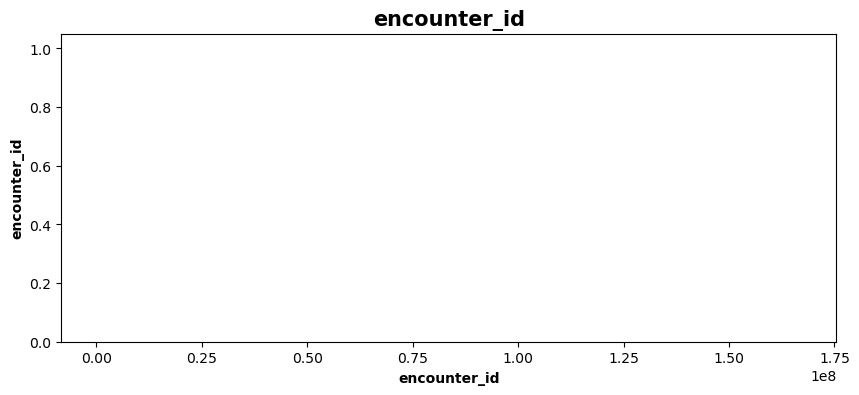


 
 
 

---- Input Variable: patient_nbr --- 

1. Value count for the patient_nbr variable: 
 patient_nbr
88785891     40
43140906     28
1660293      23
88227540     23
23199021     23
             ..
75029967      1
109518849     1
93895497      1
4295016       1
175429310     1
Name: count, Length: 71518, dtype: int64 

2. Descriptive statistics for the patient_nbr variable: 
 count    1.017660e+05
mean     5.433040e+07
std      3.869636e+07
min      1.350000e+02
25%      2.341322e+07
50%      4.550514e+07
75%      8.754595e+07
max      1.895026e+08
Name: patient_nbr, dtype: float64 

3. Number of NAs for patient_nbr variable: 0 
 

4. Histogram for the patient_nbr variable


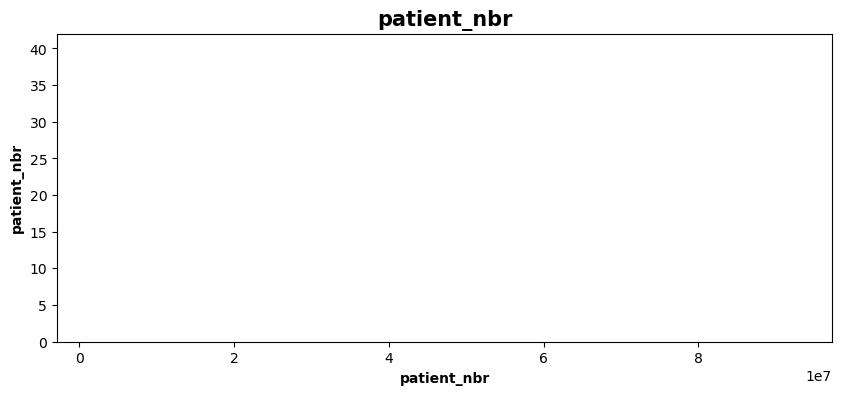


 
 
 

---- Input Variable: race --- 

1. Value count for the race variable: 
 race
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64 

2. Descriptive statistics for the race variable: 
 count         99493
unique            5
top       Caucasian
freq          76099
Name: race, dtype: object 

3. Number of NAs for race variable: 2273 
 

4. Histogram for the race variable


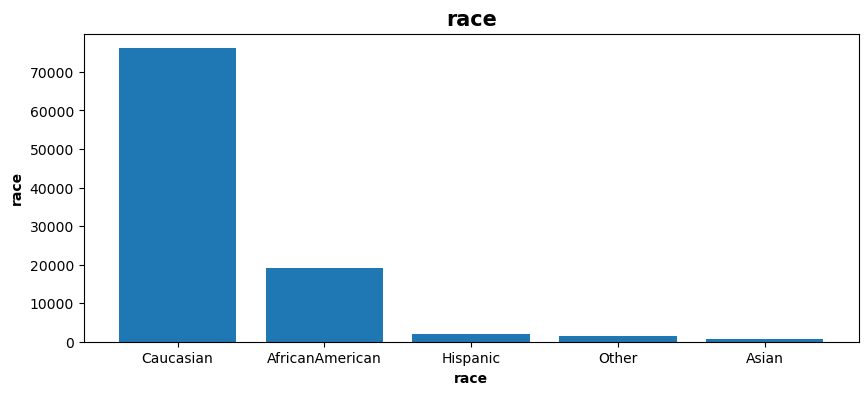


 
 
 

---- Input Variable: gender --- 

1. Value count for the gender variable: 
 gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64 

2. Descriptive statistics for the gender variable: 
 count     101766
unique         3
top       Female
freq       54708
Name: gender, dtype: object 

3. Number of NAs for gender variable: 0 
 

4. Histogram for the gender variable


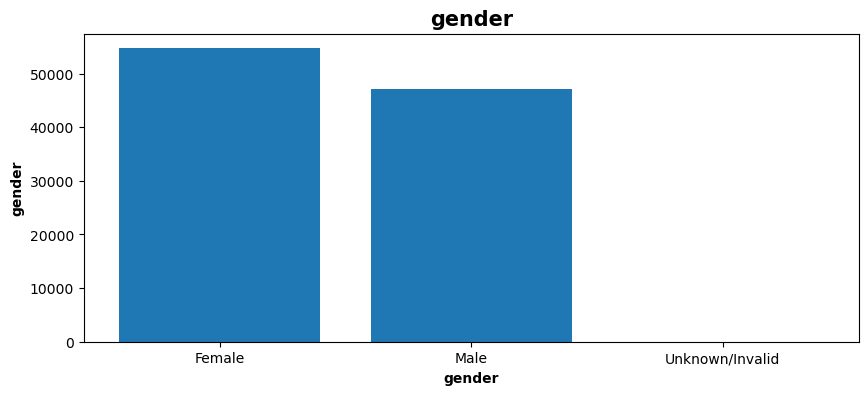


 
 
 

---- Input Variable: age --- 

1. Value count for the age variable: 
 age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64 

2. Descriptive statistics for the age variable: 
 count      101766
unique         10
top       [70-80)
freq        26068
Name: age, dtype: object 

3. Number of NAs for age variable: 0 
 

4. Histogram for the age variable


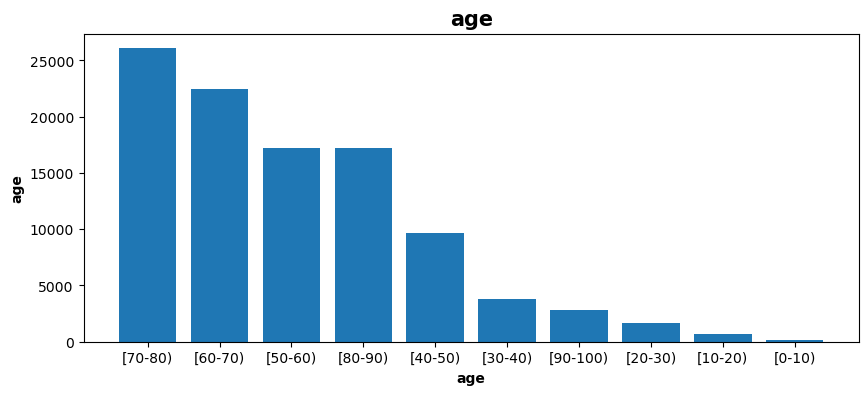


 
 
 

---- Input Variable: weight --- 

1. Value count for the weight variable: 
 weight
[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: count, dtype: int64 

2. Descriptive statistics for the weight variable: 
 count         3197
unique           9
top       [75-100)
freq          1336
Name: weight, dtype: object 

3. Number of NAs for weight variable: 98569 
 

4. Histogram for the weight variable


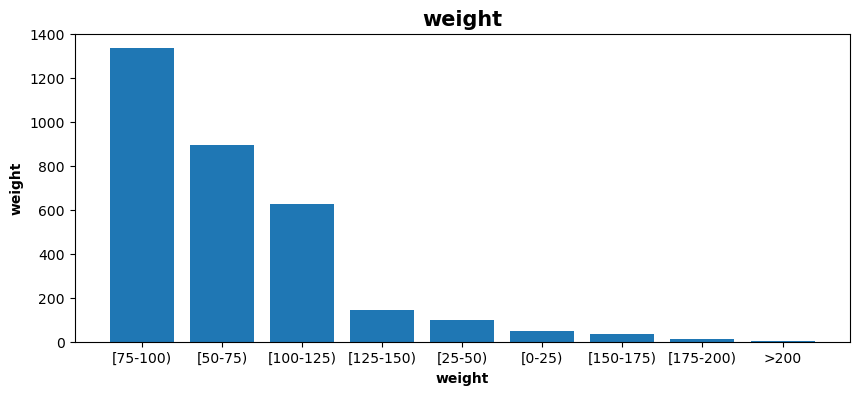


 
 
 

---- Input Variable: admission_type_id --- 

1. Value count for the admission_type_id variable: 
 admission_type_id
1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: count, dtype: int64 

2. Descriptive statistics for the admission_type_id variable: 
 count    101766.000000
mean          2.024006
std           1.445403
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max           8.000000
Name: admission_type_id, dtype: float64 

3. Number of NAs for admission_type_id variable: 0 
 

4. Histogram for the admission_type_id variable


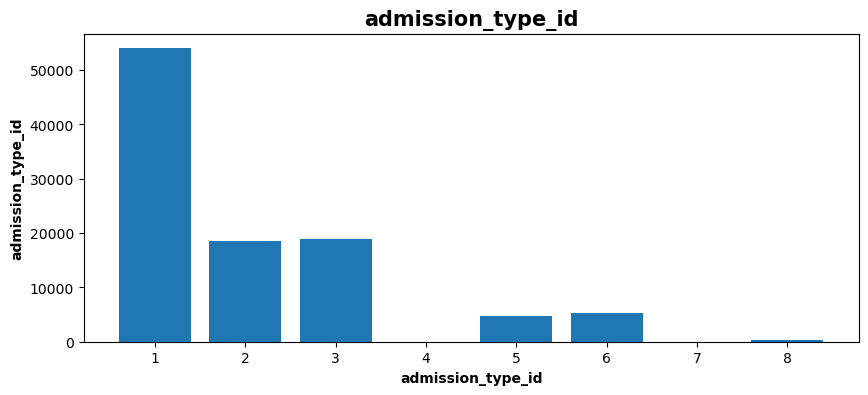


 
 
 

---- Input Variable: discharge_disposition_id --- 

1. Value count for the discharge_disposition_id variable: 
 discharge_disposition_id
1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: count, dtype: int64 

2. Descriptive statistics for the discharge_disposition_id variable: 
 count    101766.000000
mean          3.715642
std           5.280166
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          28.000000
Name: discharge_disposition_id, dtype: float64 

3. Number of NAs for discharge_disposition_id variable: 0 
 

4. Histogram for the discharge_disposition_id variable


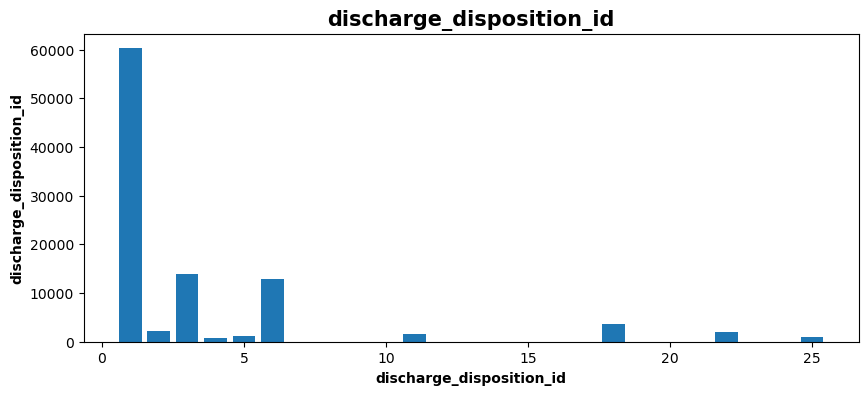


 
 
 

---- Input Variable: admission_source_id --- 

1. Value count for the admission_source_id variable: 
 admission_source_id
7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
14        2
25        2
11        2
13        1
Name: count, dtype: int64 

2. Descriptive statistics for the admission_source_id variable: 
 count    101766.000000
mean          5.754437
std           4.064081
min           1.000000
25%           1.000000
50%           7.000000
75%           7.000000
max          25.000000
Name: admission_source_id, dtype: float64 

3. Number of NAs for admission_source_id variable: 0 
 

4. Histogram for the admission_source_id variable


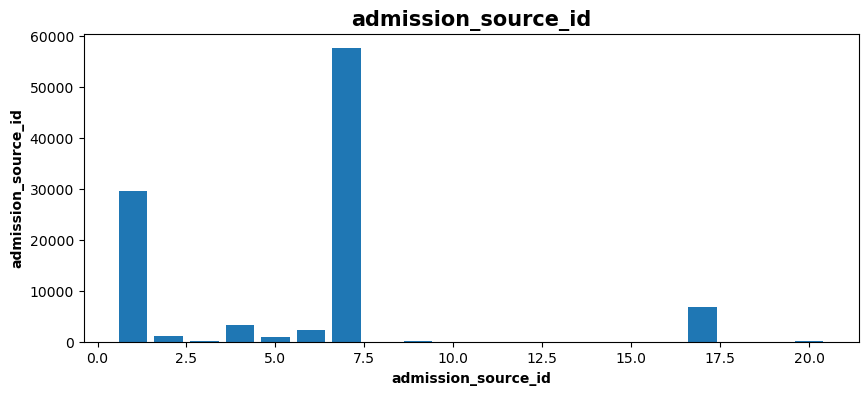


 
 
 

---- Input Variable: time_in_hospital --- 

1. Value count for the time_in_hospital variable: 
 time_in_hospital
3     17756
2     17224
1     14208
4     13924
5      9966
6      7539
7      5859
8      4391
9      3002
10     2342
11     1855
12     1448
13     1210
14     1042
Name: count, dtype: int64 

2. Descriptive statistics for the time_in_hospital variable: 
 count    101766.000000
mean          4.395987
std           2.985108
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          14.000000
Name: time_in_hospital, dtype: float64 

3. Number of NAs for time_in_hospital variable: 0 
 

4. Histogram for the time_in_hospital variable


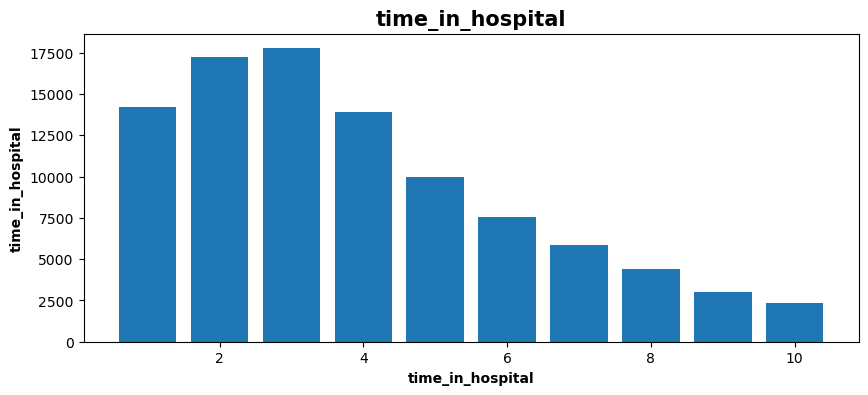


 
 
 

---- Input Variable: payer_code --- 

1. Value count for the payer_code variable: 
 payer_code
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64 

2. Descriptive statistics for the payer_code variable: 
 count     61510
unique       17
top          MC
freq      32439
Name: payer_code, dtype: object 

3. Number of NAs for payer_code variable: 40256 
 

4. Histogram for the payer_code variable


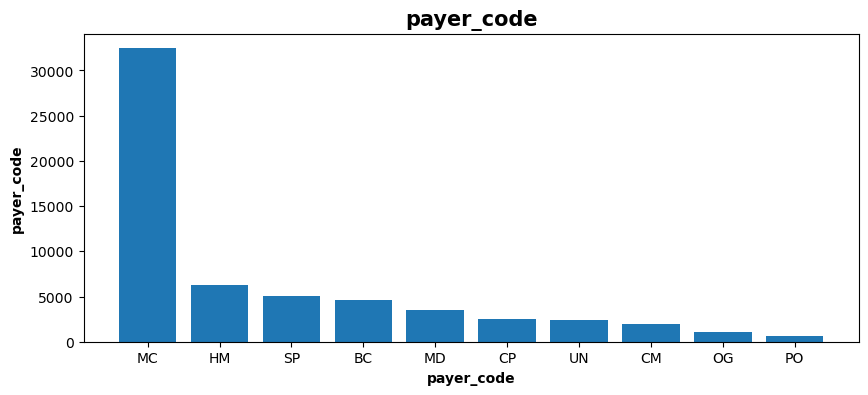


 
 
 

---- Input Variable: medical_specialty --- 

1. Value count for the medical_specialty variable: 
 medical_specialty
InternalMedicine                        14635
Emergency/Trauma                         7565
Family/GeneralPractice                   7440
Cardiology                               5352
Surgery-General                          3099
Nephrology                               1613
Orthopedics                              1400
Orthopedics-Reconstructive               1233
Radiologist                              1140
Pulmonology                               871
Psychiatry                                854
Urology                                   685
ObstetricsandGynecology                   671
Surgery-Cardiovascular/Thoracic           652
Gastroenterology                          564
Surgery-Vascular                          533
Surgery-Neuro                             468
PhysicalMedicineandRehabilitation         391
Oncology                                  348
Pe

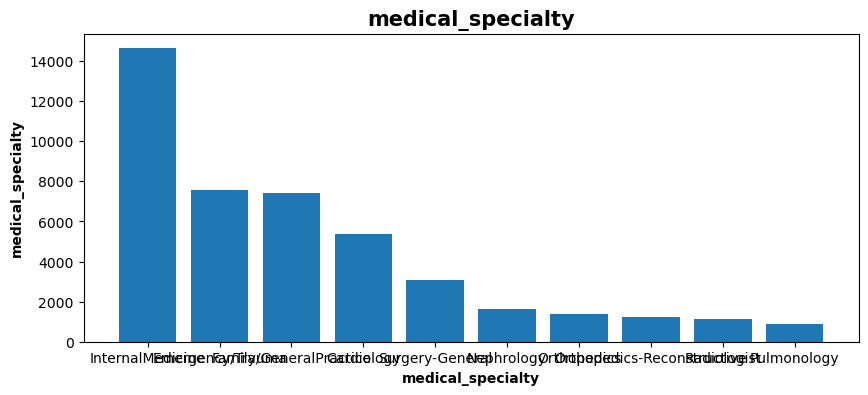


 
 
 

---- Input Variable: num_lab_procedures --- 

1. Value count for the num_lab_procedures variable: 
 num_lab_procedures
1      3208
43     2804
44     2496
45     2376
38     2213
40     2201
46     2189
41     2117
42     2113
47     2106
39     2101
37     2079
49     2066
48     2058
36     1962
51     1925
50     1924
35     1907
54     1888
56     1839
52     1838
55     1836
53     1802
57     1747
58     1708
34     1677
61     1638
59     1624
60     1610
63     1450
62     1444
30     1354
29     1340
32     1336
64     1324
31     1311
33     1297
65     1238
66     1212
2      1101
26     1094
67     1093
28     1048
25     1048
68     1043
69      991
19      977
9       933
10      838
23      836
27      831
70      826
71      798
20      763
72      749
24      744
17      743
18      730
22      694
11      689
21      676
3       668
73      661
74      612
16      544
75      526
12      506
76      465
15      461
77      421
13      404
4       378
8       3

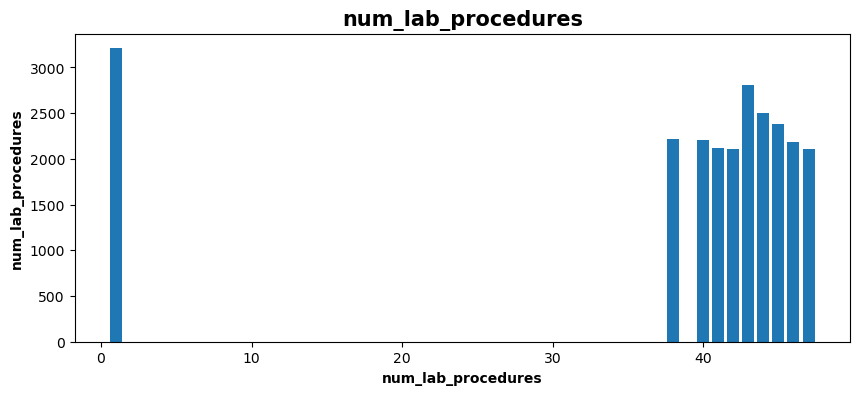


 
 
 

---- Input Variable: num_procedures --- 

1. Value count for the num_procedures variable: 
 num_procedures
0    46652
1    20742
2    12717
3     9443
6     4954
4     4180
5     3078
Name: count, dtype: int64 

2. Descriptive statistics for the num_procedures variable: 
 count    101766.000000
mean          1.339730
std           1.705807
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: num_procedures, dtype: float64 

3. Number of NAs for num_procedures variable: 0 
 

4. Histogram for the num_procedures variable


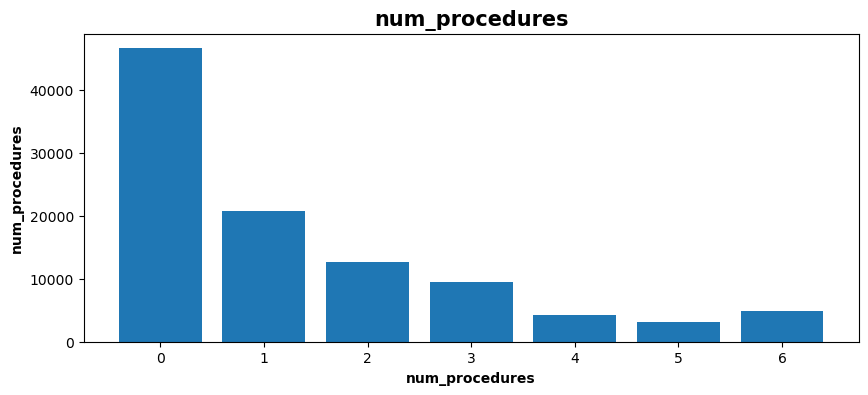


 
 
 

---- Input Variable: num_medications --- 

1. Value count for the num_medications variable: 
 num_medications
13    6086
12    6004
11    5795
15    5792
14    5707
16    5430
10    5346
17    4919
9     4913
18    4523
8     4353
19    4078
20    3691
7     3484
21    3230
22    2868
6     2699
23    2426
24    2109
5     2017
25    1888
26    1608
27    1432
4     1417
28    1233
29    1000
3      900
30     849
31     712
32     623
33     504
2      470
34     453
35     388
37     293
36     287
1      262
38     228
39     209
40     179
41     146
42     128
43     127
44     100
46      92
45      88
47      74
49      61
48      60
50      55
52      54
51      43
53      40
56      37
54      33
55      32
57      26
58      25
60      23
59      20
62      15
63      14
61      14
65      12
64       8
67       7
68       7
69       5
66       5
72       3
70       2
75       2
81       1
79       1
74       1
Name: count, dtype: int64 

2. Descriptive statistics for

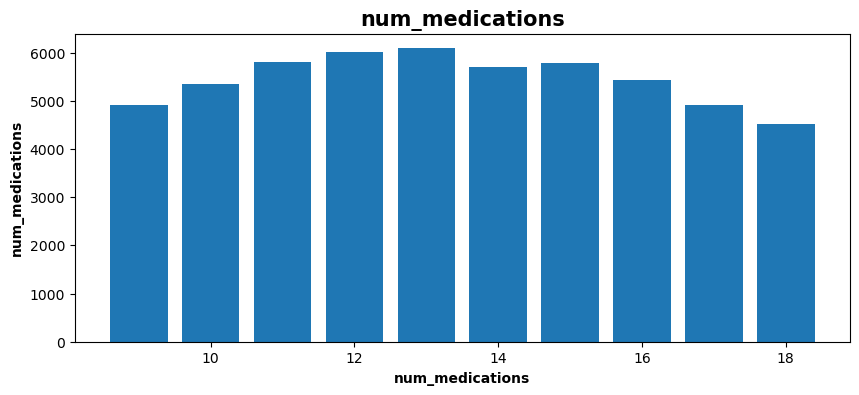


 
 
 

---- Input Variable: number_outpatient --- 

1. Value count for the number_outpatient variable: 
 number_outpatient
0     85027
1      8547
2      3594
3      2042
4      1099
5       533
6       303
7       155
8        98
9        83
10       57
11       42
13       31
12       30
14       28
15       20
16       15
17        8
21        7
20        7
18        5
22        5
24        3
27        3
19        3
23        2
29        2
36        2
35        2
26        2
33        2
25        2
28        1
38        1
37        1
39        1
34        1
42        1
40        1
Name: count, dtype: int64 

2. Descriptive statistics for the number_outpatient variable: 
 count    101766.000000
mean          0.369357
std           1.267265
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          42.000000
Name: number_outpatient, dtype: float64 

3. Number of NAs for number_outpatient variable: 0 
 

4. Histogram for the number_outpati

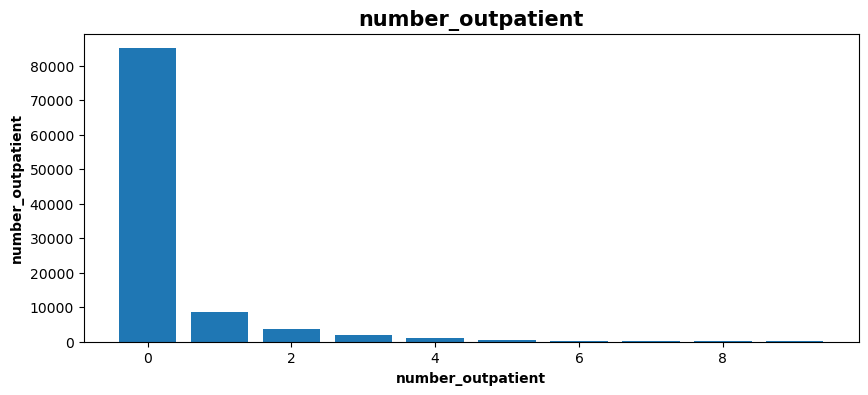


 
 
 

---- Input Variable: number_emergency --- 

1. Value count for the number_emergency variable: 
 number_emergency
0     90383
1      7677
2      2042
3       725
4       374
5       192
6        94
7        73
8        50
10       34
9        33
11       23
13       12
12       10
22        6
16        5
18        5
20        4
19        4
14        3
15        3
25        2
21        2
42        1
54        1
28        1
46        1
76        1
37        1
64        1
63        1
24        1
29        1
Name: count, dtype: int64 

2. Descriptive statistics for the number_emergency variable: 
 count    101766.000000
mean          0.197836
std           0.930472
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          76.000000
Name: number_emergency, dtype: float64 

3. Number of NAs for number_emergency variable: 0 
 

4. Histogram for the number_emergency variable


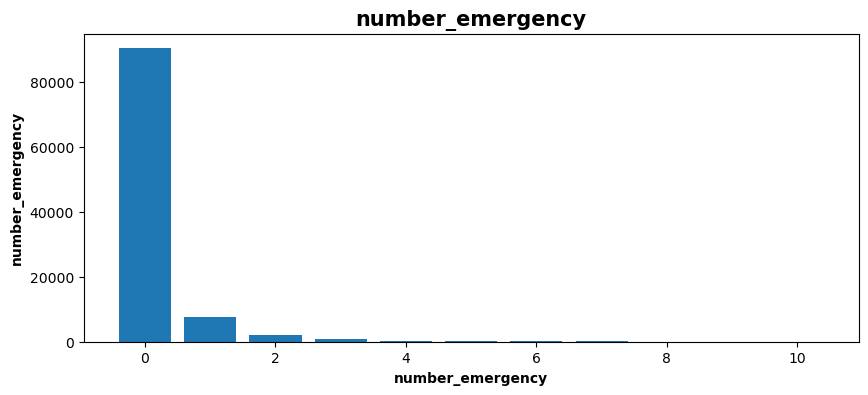


 
 
 

---- Input Variable: number_inpatient --- 

1. Value count for the number_inpatient variable: 
 number_inpatient
0     67630
1     19521
2      7566
3      3411
4      1622
5       812
6       480
7       268
8       151
9       111
10       61
11       49
12       34
13       20
14       10
15        9
16        6
19        2
17        1
21        1
18        1
Name: count, dtype: int64 

2. Descriptive statistics for the number_inpatient variable: 
 count    101766.000000
mean          0.635566
std           1.262863
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          21.000000
Name: number_inpatient, dtype: float64 

3. Number of NAs for number_inpatient variable: 0 
 

4. Histogram for the number_inpatient variable


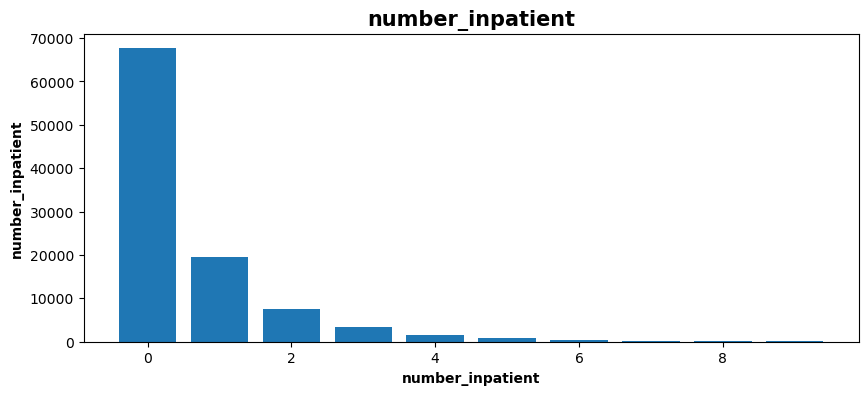


 
 
 

---- Input Variable: diag_1 --- 

1. Value count for the diag_1 variable: 
 diag_1
428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
671       1
640       1
827       1
373       1
V51       1
Name: count, Length: 716, dtype: int64 

2. Descriptive statistics for the diag_1 variable: 
 count     101745
unique       716
top          428
freq        6862
Name: diag_1, dtype: object 

3. Number of NAs for diag_1 variable: 21 
 

4. Histogram for the diag_1 variable


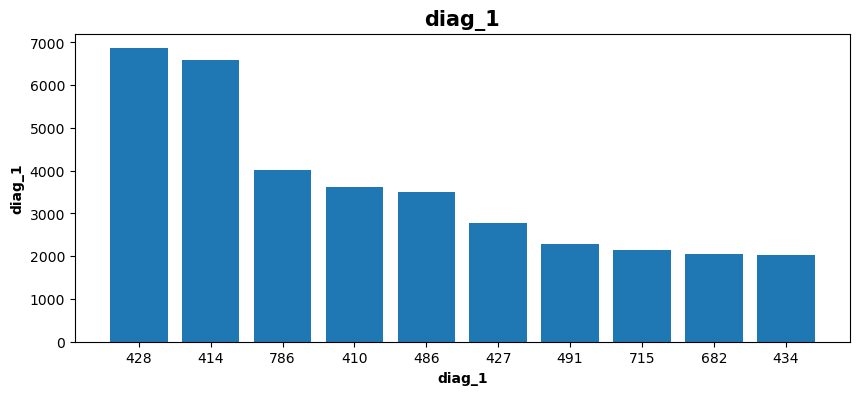


 
 
 

---- Input Variable: diag_2 --- 

1. Value count for the diag_2 variable: 
 diag_2
276    6752
428    6662
250    6071
427    5036
401    3736
       ... 
811       1
962       1
833       1
615       1
927       1
Name: count, Length: 748, dtype: int64 

2. Descriptive statistics for the diag_2 variable: 
 count     101408
unique       748
top          276
freq        6752
Name: diag_2, dtype: object 

3. Number of NAs for diag_2 variable: 358 
 

4. Histogram for the diag_2 variable


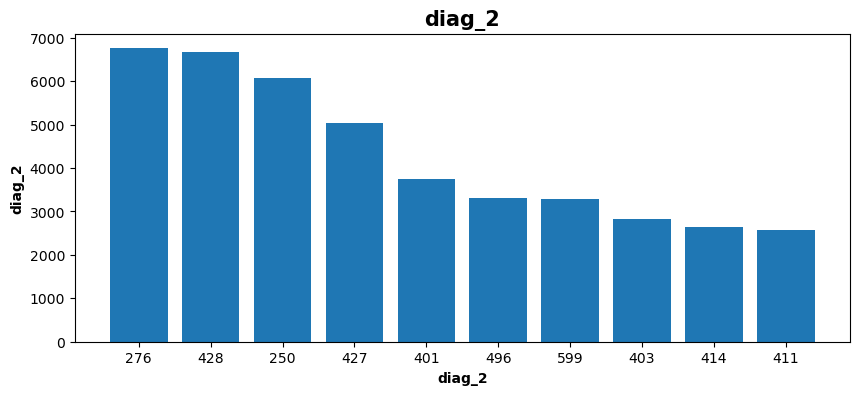


 
 
 

---- Input Variable: diag_3 --- 

1. Value count for the diag_3 variable: 
 diag_3
250     11555
401      8289
276      5175
428      4577
427      3955
        ...  
V07         1
66          1
265         1
E955        1
971         1
Name: count, Length: 789, dtype: int64 

2. Descriptive statistics for the diag_3 variable: 
 count     100343
unique       789
top          250
freq       11555
Name: diag_3, dtype: object 

3. Number of NAs for diag_3 variable: 1423 
 

4. Histogram for the diag_3 variable


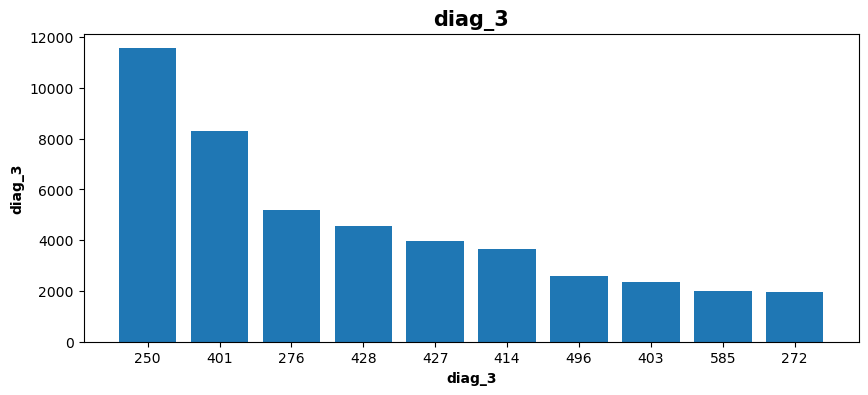


 
 
 

---- Input Variable: number_diagnoses --- 

1. Value count for the number_diagnoses variable: 
 number_diagnoses
9     49474
5     11393
8     10616
7     10393
6     10161
4      5537
3      2835
2      1023
1       219
16       45
10       17
13       16
11       11
15       10
12        9
14        7
Name: count, dtype: int64 

2. Descriptive statistics for the number_diagnoses variable: 
 count    101766.000000
mean          7.422607
std           1.933600
min           1.000000
25%           6.000000
50%           8.000000
75%           9.000000
max          16.000000
Name: number_diagnoses, dtype: float64 

3. Number of NAs for number_diagnoses variable: 0 
 

4. Histogram for the number_diagnoses variable


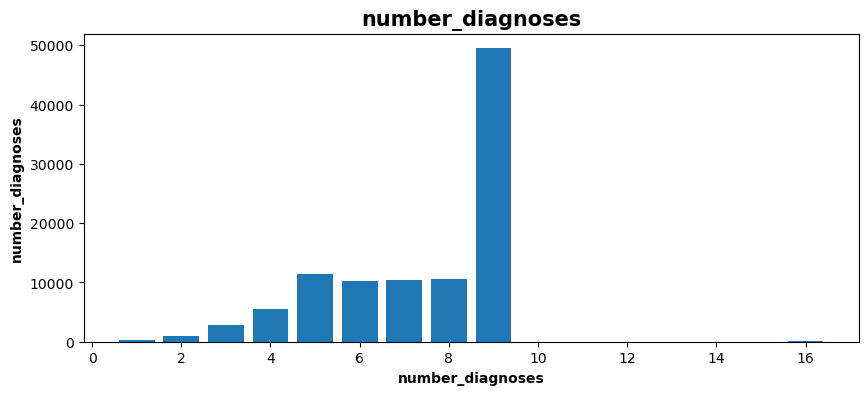


 
 
 

---- Input Variable: max_glu_serum --- 

1. Value count for the max_glu_serum variable: 
 max_glu_serum
Norm    2597
>200    1485
>300    1264
Name: count, dtype: int64 

2. Descriptive statistics for the max_glu_serum variable: 
 count     5346
unique       3
top       Norm
freq      2597
Name: max_glu_serum, dtype: object 

3. Number of NAs for max_glu_serum variable: 96420 
 

4. Histogram for the max_glu_serum variable


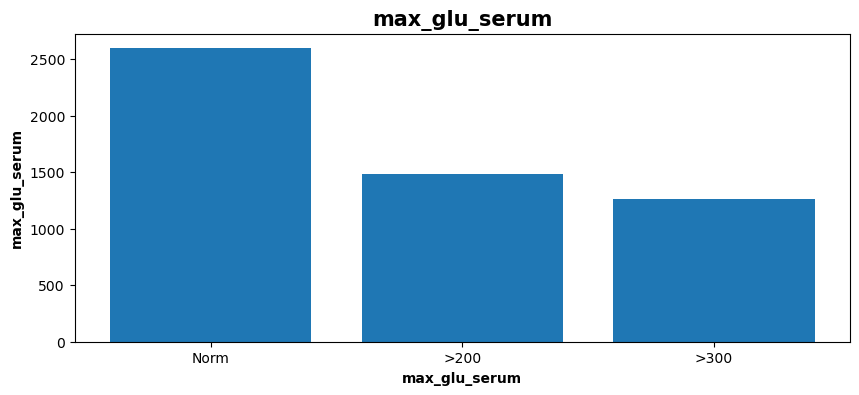


 
 
 

---- Input Variable: A1Cresult --- 

1. Value count for the A1Cresult variable: 
 A1Cresult
>8      8216
Norm    4990
>7      3812
Name: count, dtype: int64 

2. Descriptive statistics for the A1Cresult variable: 
 count     17018
unique        3
top          >8
freq       8216
Name: A1Cresult, dtype: object 

3. Number of NAs for A1Cresult variable: 84748 
 

4. Histogram for the A1Cresult variable


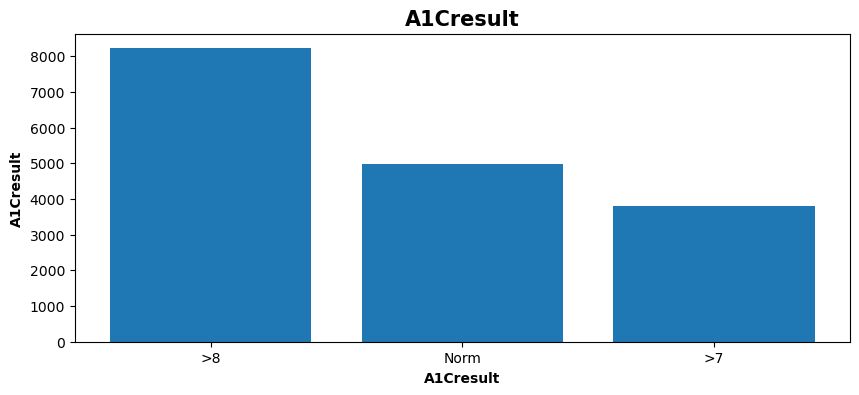


 
 
 

---- Input Variable: metformin --- 

1. Value count for the metformin variable: 
 metformin
No        81778
Steady    18346
Up         1067
Down        575
Name: count, dtype: int64 

2. Descriptive statistics for the metformin variable: 
 count     101766
unique         4
top           No
freq       81778
Name: metformin, dtype: object 

3. Number of NAs for metformin variable: 0 
 

4. Histogram for the metformin variable


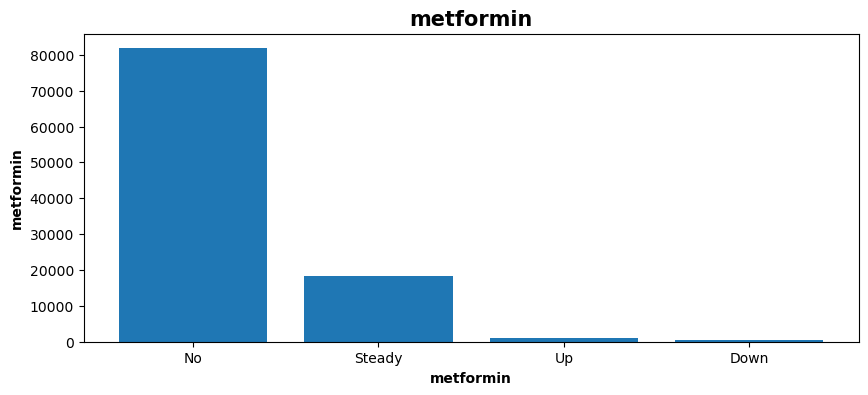


 
 
 

---- Input Variable: repaglinide --- 

1. Value count for the repaglinide variable: 
 repaglinide
No        100227
Steady      1384
Up           110
Down          45
Name: count, dtype: int64 

2. Descriptive statistics for the repaglinide variable: 
 count     101766
unique         4
top           No
freq      100227
Name: repaglinide, dtype: object 

3. Number of NAs for repaglinide variable: 0 
 

4. Histogram for the repaglinide variable


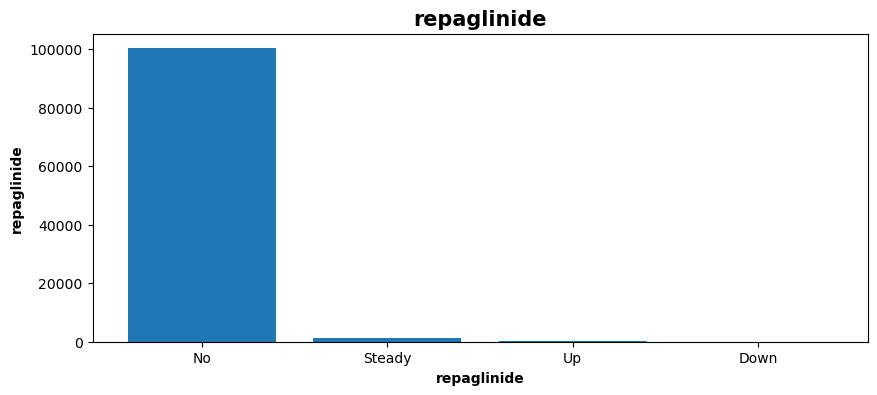


 
 
 

---- Input Variable: nateglinide --- 

1. Value count for the nateglinide variable: 
 nateglinide
No        101063
Steady       668
Up            24
Down          11
Name: count, dtype: int64 

2. Descriptive statistics for the nateglinide variable: 
 count     101766
unique         4
top           No
freq      101063
Name: nateglinide, dtype: object 

3. Number of NAs for nateglinide variable: 0 
 

4. Histogram for the nateglinide variable


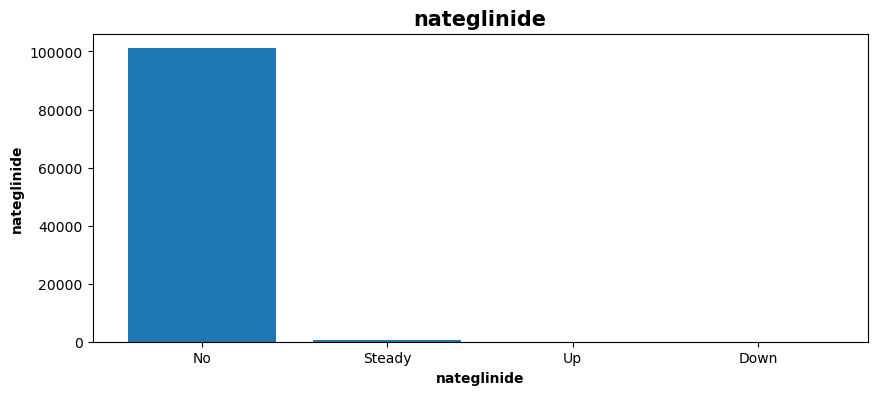


 
 
 

---- Input Variable: chlorpropamide --- 

1. Value count for the chlorpropamide variable: 
 chlorpropamide
No        101680
Steady        79
Up             6
Down           1
Name: count, dtype: int64 

2. Descriptive statistics for the chlorpropamide variable: 
 count     101766
unique         4
top           No
freq      101680
Name: chlorpropamide, dtype: object 

3. Number of NAs for chlorpropamide variable: 0 
 

4. Histogram for the chlorpropamide variable


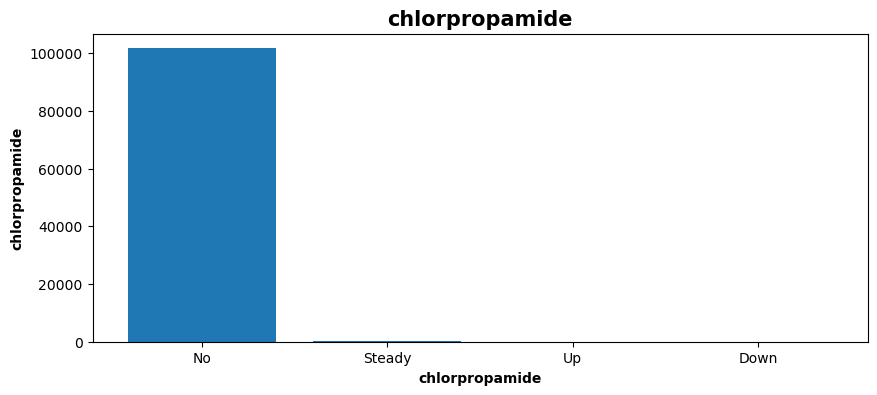


 
 
 

---- Input Variable: glimepiride --- 

1. Value count for the glimepiride variable: 
 glimepiride
No        96575
Steady     4670
Up          327
Down        194
Name: count, dtype: int64 

2. Descriptive statistics for the glimepiride variable: 
 count     101766
unique         4
top           No
freq       96575
Name: glimepiride, dtype: object 

3. Number of NAs for glimepiride variable: 0 
 

4. Histogram for the glimepiride variable


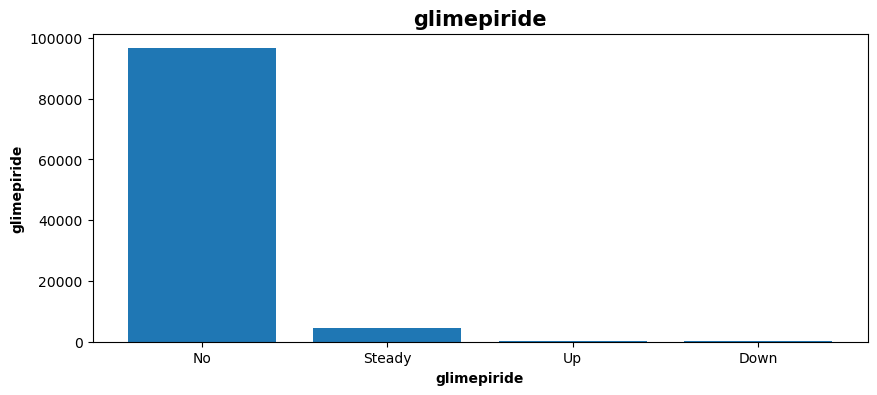


 
 
 

---- Input Variable: acetohexamide --- 

1. Value count for the acetohexamide variable: 
 acetohexamide
No        101765
Steady         1
Name: count, dtype: int64 

2. Descriptive statistics for the acetohexamide variable: 
 count     101766
unique         2
top           No
freq      101765
Name: acetohexamide, dtype: object 

3. Number of NAs for acetohexamide variable: 0 
 

4. Histogram for the acetohexamide variable


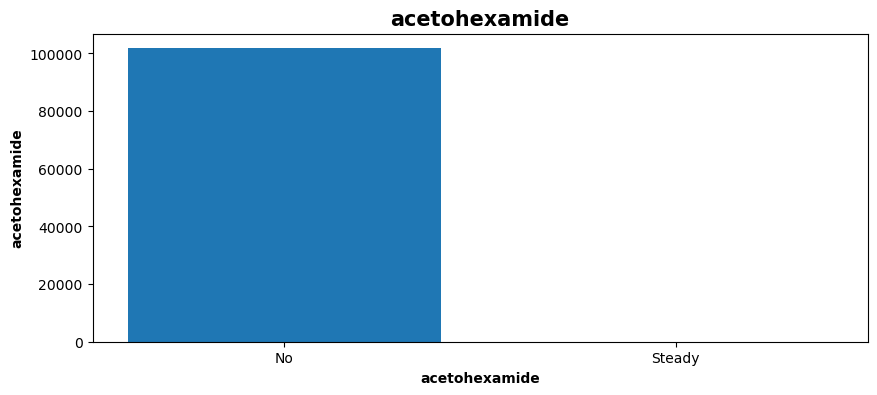


 
 
 

---- Input Variable: glipizide --- 

1. Value count for the glipizide variable: 
 glipizide
No        89080
Steady    11356
Up          770
Down        560
Name: count, dtype: int64 

2. Descriptive statistics for the glipizide variable: 
 count     101766
unique         4
top           No
freq       89080
Name: glipizide, dtype: object 

3. Number of NAs for glipizide variable: 0 
 

4. Histogram for the glipizide variable


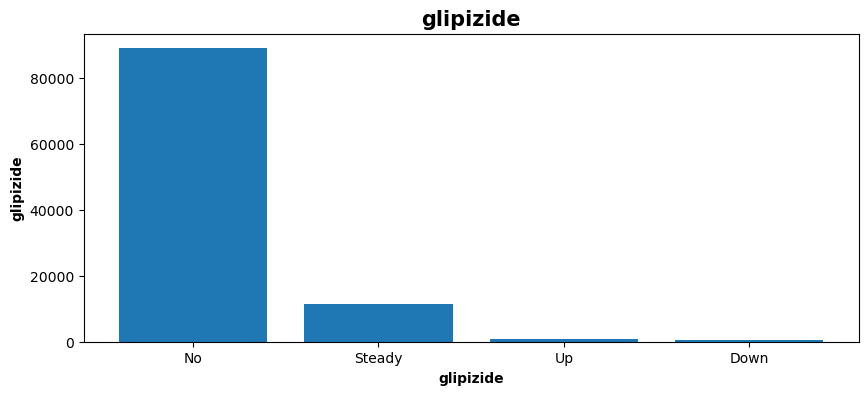


 
 
 

---- Input Variable: glyburide --- 

1. Value count for the glyburide variable: 
 glyburide
No        91116
Steady     9274
Up          812
Down        564
Name: count, dtype: int64 

2. Descriptive statistics for the glyburide variable: 
 count     101766
unique         4
top           No
freq       91116
Name: glyburide, dtype: object 

3. Number of NAs for glyburide variable: 0 
 

4. Histogram for the glyburide variable


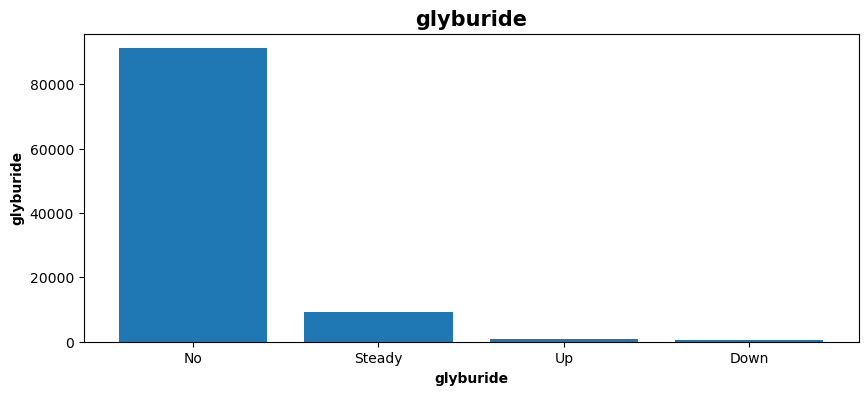


 
 
 

---- Input Variable: tolbutamide --- 

1. Value count for the tolbutamide variable: 
 tolbutamide
No        101743
Steady        23
Name: count, dtype: int64 

2. Descriptive statistics for the tolbutamide variable: 
 count     101766
unique         2
top           No
freq      101743
Name: tolbutamide, dtype: object 

3. Number of NAs for tolbutamide variable: 0 
 

4. Histogram for the tolbutamide variable


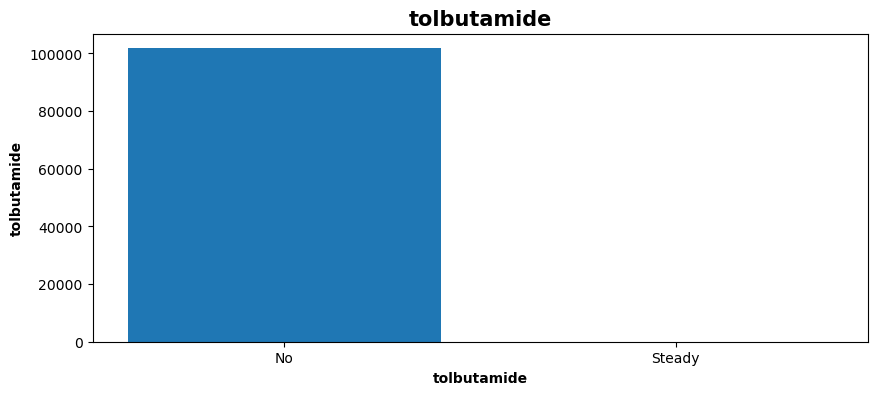


 
 
 

---- Input Variable: pioglitazone --- 

1. Value count for the pioglitazone variable: 
 pioglitazone
No        94438
Steady     6976
Up          234
Down        118
Name: count, dtype: int64 

2. Descriptive statistics for the pioglitazone variable: 
 count     101766
unique         4
top           No
freq       94438
Name: pioglitazone, dtype: object 

3. Number of NAs for pioglitazone variable: 0 
 

4. Histogram for the pioglitazone variable


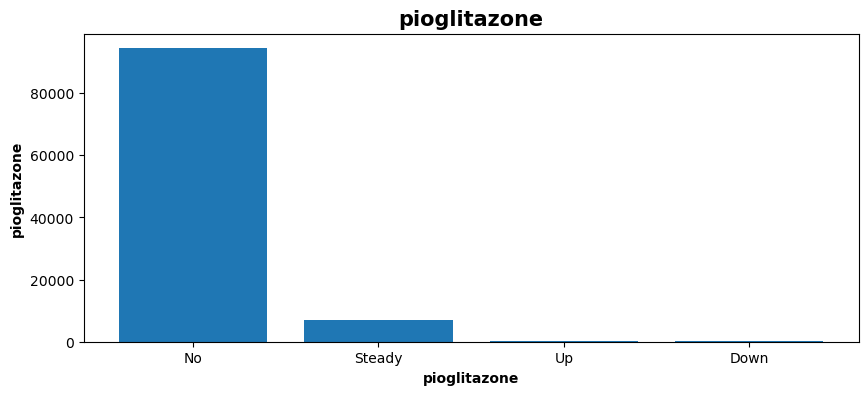


 
 
 

---- Input Variable: rosiglitazone --- 

1. Value count for the rosiglitazone variable: 
 rosiglitazone
No        95401
Steady     6100
Up          178
Down         87
Name: count, dtype: int64 

2. Descriptive statistics for the rosiglitazone variable: 
 count     101766
unique         4
top           No
freq       95401
Name: rosiglitazone, dtype: object 

3. Number of NAs for rosiglitazone variable: 0 
 

4. Histogram for the rosiglitazone variable


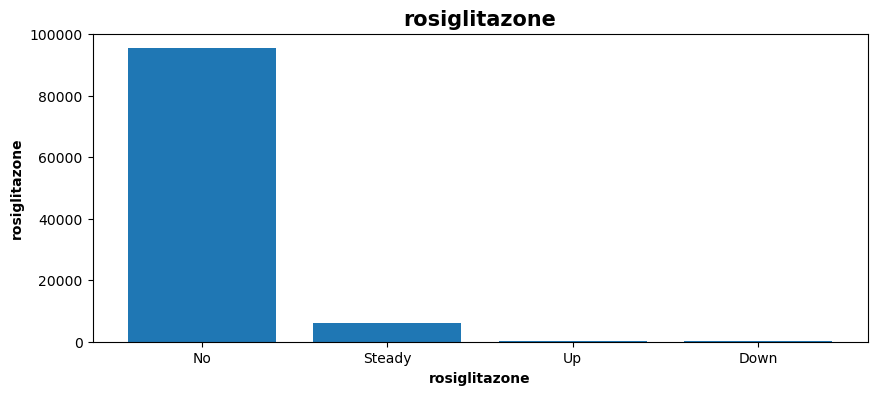


 
 
 

---- Input Variable: acarbose --- 

1. Value count for the acarbose variable: 
 acarbose
No        101458
Steady       295
Up            10
Down           3
Name: count, dtype: int64 

2. Descriptive statistics for the acarbose variable: 
 count     101766
unique         4
top           No
freq      101458
Name: acarbose, dtype: object 

3. Number of NAs for acarbose variable: 0 
 

4. Histogram for the acarbose variable


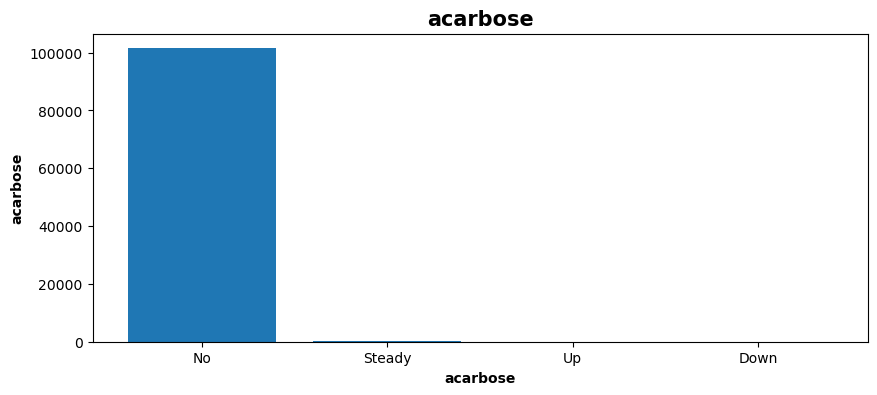


 
 
 

---- Input Variable: miglitol --- 

1. Value count for the miglitol variable: 
 miglitol
No        101728
Steady        31
Down           5
Up             2
Name: count, dtype: int64 

2. Descriptive statistics for the miglitol variable: 
 count     101766
unique         4
top           No
freq      101728
Name: miglitol, dtype: object 

3. Number of NAs for miglitol variable: 0 
 

4. Histogram for the miglitol variable


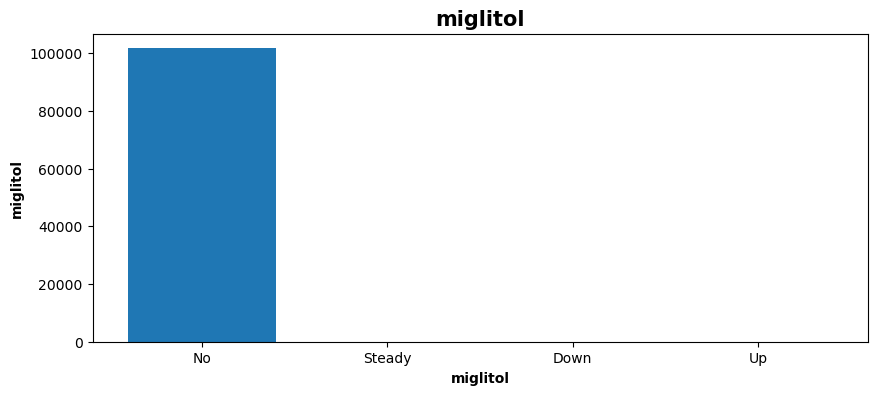


 
 
 

---- Input Variable: troglitazone --- 

1. Value count for the troglitazone variable: 
 troglitazone
No        101763
Steady         3
Name: count, dtype: int64 

2. Descriptive statistics for the troglitazone variable: 
 count     101766
unique         2
top           No
freq      101763
Name: troglitazone, dtype: object 

3. Number of NAs for troglitazone variable: 0 
 

4. Histogram for the troglitazone variable


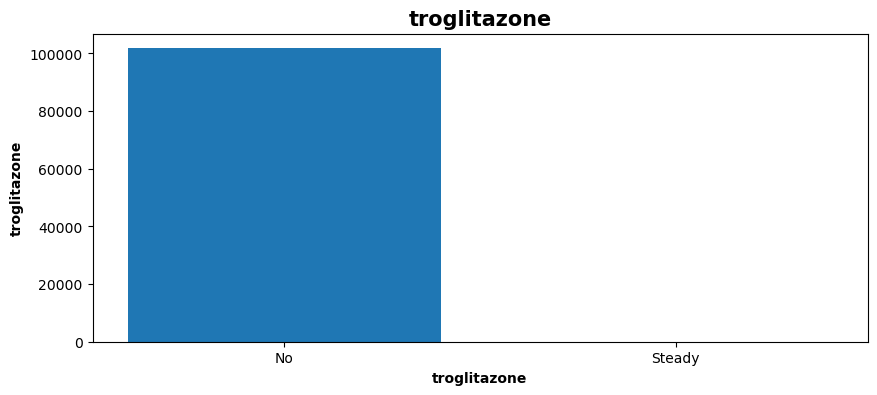


 
 
 

---- Input Variable: tolazamide --- 

1. Value count for the tolazamide variable: 
 tolazamide
No        101727
Steady        38
Up             1
Name: count, dtype: int64 

2. Descriptive statistics for the tolazamide variable: 
 count     101766
unique         3
top           No
freq      101727
Name: tolazamide, dtype: object 

3. Number of NAs for tolazamide variable: 0 
 

4. Histogram for the tolazamide variable


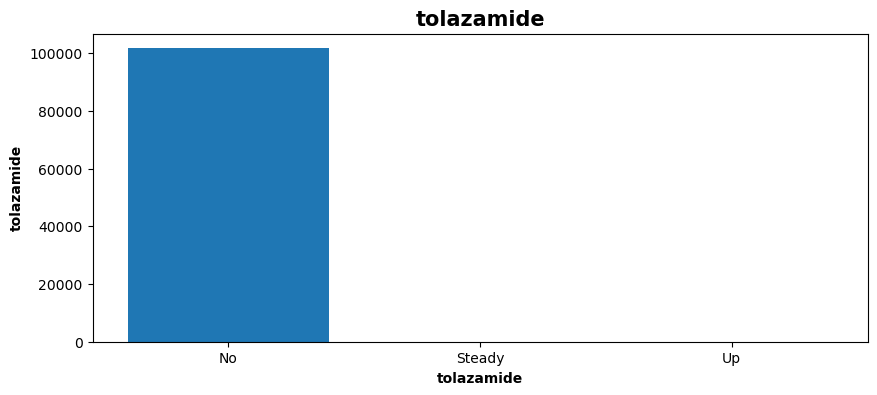


 
 
 

---- Input Variable: examide --- 

1. Value count for the examide variable: 
 examide
No    101766
Name: count, dtype: int64 

2. Descriptive statistics for the examide variable: 
 count     101766
unique         1
top           No
freq      101766
Name: examide, dtype: object 

3. Number of NAs for examide variable: 0 
 

4. Histogram for the examide variable


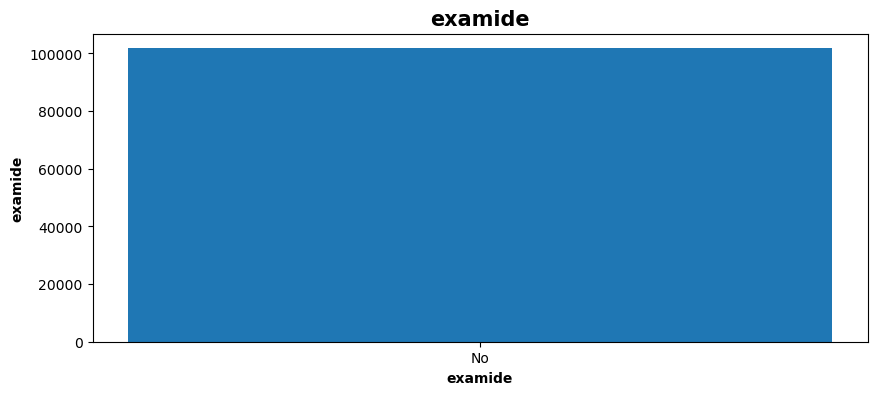


 
 
 

---- Input Variable: citoglipton --- 

1. Value count for the citoglipton variable: 
 citoglipton
No    101766
Name: count, dtype: int64 

2. Descriptive statistics for the citoglipton variable: 
 count     101766
unique         1
top           No
freq      101766
Name: citoglipton, dtype: object 

3. Number of NAs for citoglipton variable: 0 
 

4. Histogram for the citoglipton variable


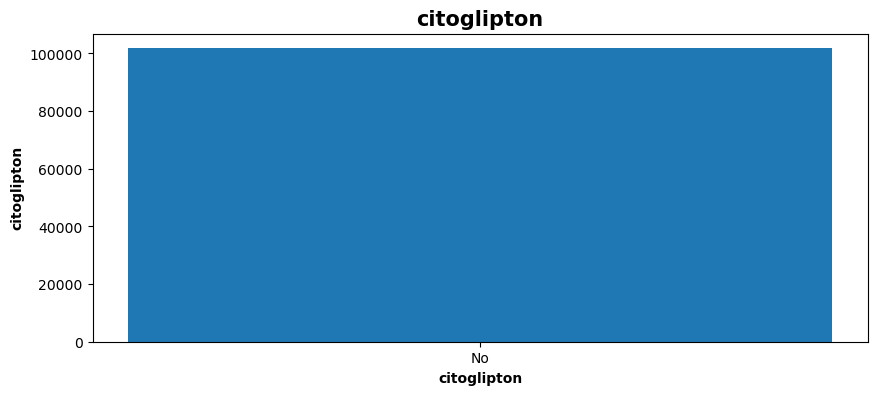


 
 
 

---- Input Variable: insulin --- 

1. Value count for the insulin variable: 
 insulin
No        47383
Steady    30849
Down      12218
Up        11316
Name: count, dtype: int64 

2. Descriptive statistics for the insulin variable: 
 count     101766
unique         4
top           No
freq       47383
Name: insulin, dtype: object 

3. Number of NAs for insulin variable: 0 
 

4. Histogram for the insulin variable


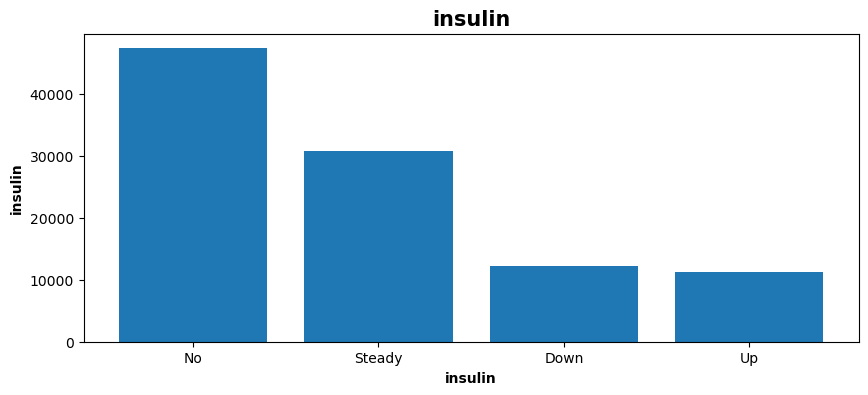


 
 
 

---- Input Variable: glyburide.metformin --- 

1. Value count for the glyburide.metformin variable: 
 glyburide.metformin
No        101060
Steady       692
Up             8
Down           6
Name: count, dtype: int64 

2. Descriptive statistics for the glyburide.metformin variable: 
 count     101766
unique         4
top           No
freq      101060
Name: glyburide.metformin, dtype: object 

3. Number of NAs for glyburide.metformin variable: 0 
 

4. Histogram for the glyburide.metformin variable


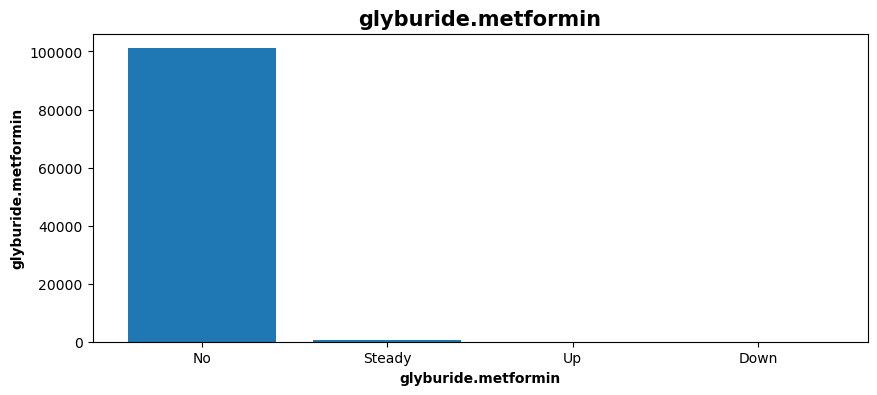


 
 
 

---- Input Variable: glipizide.metformin --- 

1. Value count for the glipizide.metformin variable: 
 glipizide.metformin
No        101753
Steady        13
Name: count, dtype: int64 

2. Descriptive statistics for the glipizide.metformin variable: 
 count     101766
unique         2
top           No
freq      101753
Name: glipizide.metformin, dtype: object 

3. Number of NAs for glipizide.metformin variable: 0 
 

4. Histogram for the glipizide.metformin variable


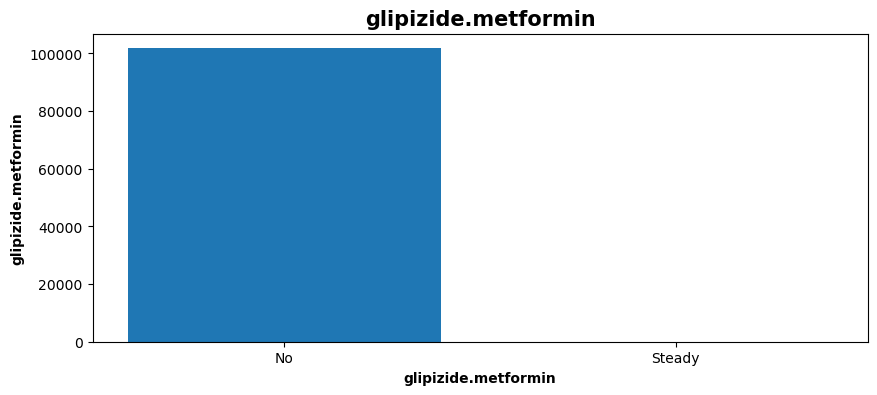


 
 
 

---- Input Variable: glimepiride.pioglitazone --- 

1. Value count for the glimepiride.pioglitazone variable: 
 glimepiride.pioglitazone
No        101765
Steady         1
Name: count, dtype: int64 

2. Descriptive statistics for the glimepiride.pioglitazone variable: 
 count     101766
unique         2
top           No
freq      101765
Name: glimepiride.pioglitazone, dtype: object 

3. Number of NAs for glimepiride.pioglitazone variable: 0 
 

4. Histogram for the glimepiride.pioglitazone variable


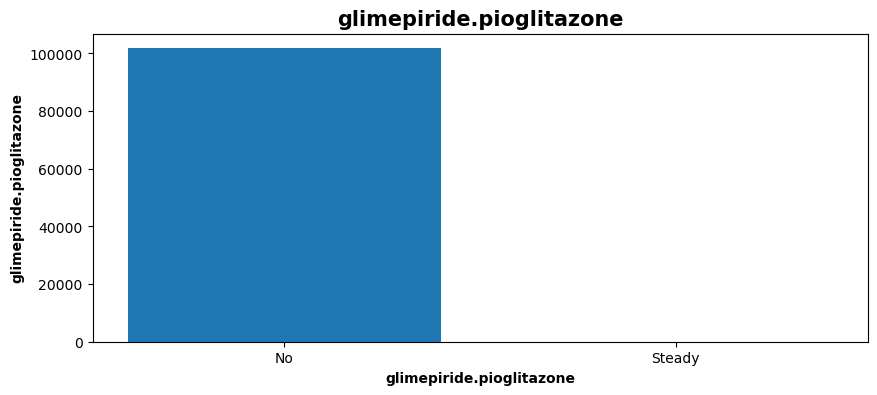


 
 
 

---- Input Variable: metformin.rosiglitazone --- 

1. Value count for the metformin.rosiglitazone variable: 
 metformin.rosiglitazone
No        101764
Steady         2
Name: count, dtype: int64 

2. Descriptive statistics for the metformin.rosiglitazone variable: 
 count     101766
unique         2
top           No
freq      101764
Name: metformin.rosiglitazone, dtype: object 

3. Number of NAs for metformin.rosiglitazone variable: 0 
 

4. Histogram for the metformin.rosiglitazone variable


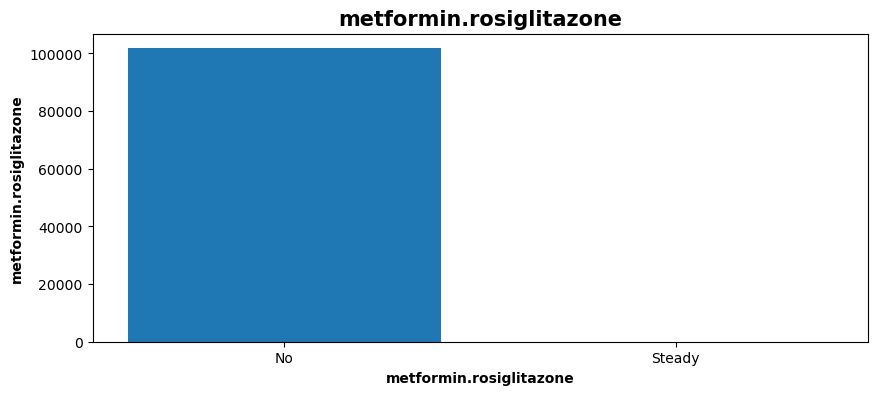


 
 
 

---- Input Variable: metformin.pioglitazone --- 

1. Value count for the metformin.pioglitazone variable: 
 metformin.pioglitazone
No        101765
Steady         1
Name: count, dtype: int64 

2. Descriptive statistics for the metformin.pioglitazone variable: 
 count     101766
unique         2
top           No
freq      101765
Name: metformin.pioglitazone, dtype: object 

3. Number of NAs for metformin.pioglitazone variable: 0 
 

4. Histogram for the metformin.pioglitazone variable


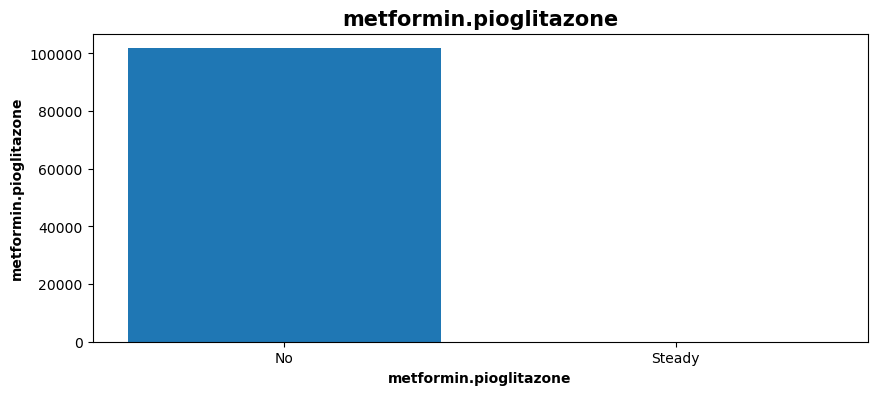


 
 
 

---- Input Variable: change --- 

1. Value count for the change variable: 
 change
No    54755
Ch    47011
Name: count, dtype: int64 

2. Descriptive statistics for the change variable: 
 count     101766
unique         2
top           No
freq       54755
Name: change, dtype: object 

3. Number of NAs for change variable: 0 
 

4. Histogram for the change variable


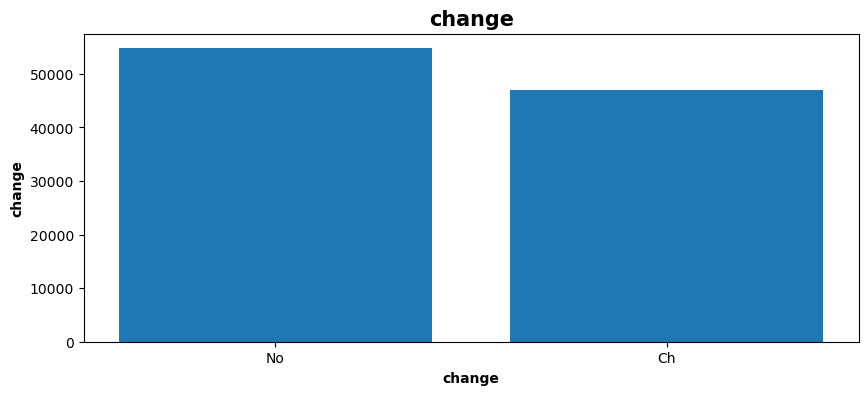


 
 
 

---- Input Variable: diabetesMed --- 

1. Value count for the diabetesMed variable: 
 diabetesMed
Yes    78363
No     23403
Name: count, dtype: int64 

2. Descriptive statistics for the diabetesMed variable: 
 count     101766
unique         2
top          Yes
freq       78363
Name: diabetesMed, dtype: object 

3. Number of NAs for diabetesMed variable: 0 
 

4. Histogram for the diabetesMed variable


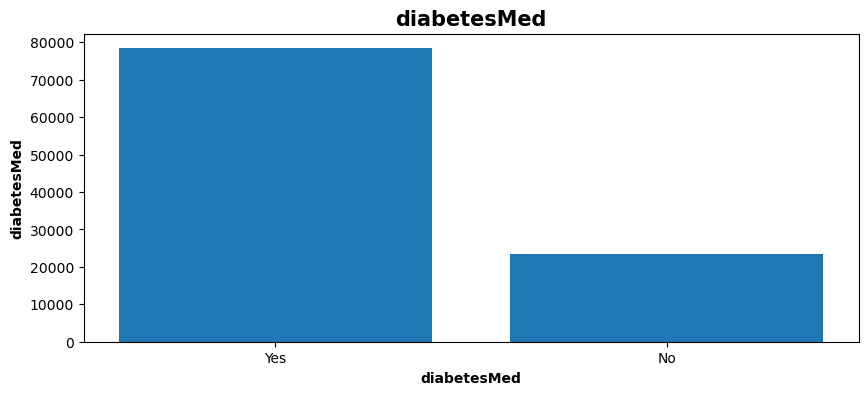


 
 
 

---- Input Variable: readmitted --- 

1. Value count for the readmitted variable: 
 readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64 

2. Descriptive statistics for the readmitted variable: 
 count     101766
unique         3
top           NO
freq       54864
Name: readmitted, dtype: object 

3. Number of NAs for readmitted variable: 0 
 

4. Histogram for the readmitted variable


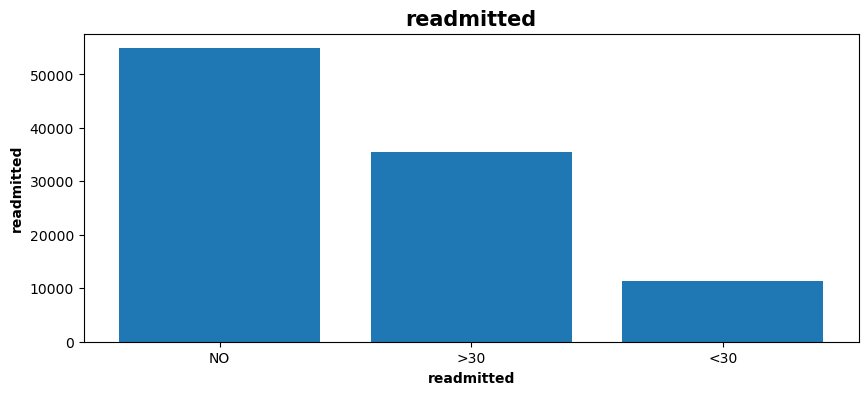

In [7]:
Exploratory_Data_Analysis(diabetes, diabetes.columns)

#### Before we sequentially format/clean each variable, let us take some initial cleaning steps deemed appropriate from the prior exploratory data analysis.

This cleaning and engineering will fall into the 4 categories below: 

    3 Data Cleaning: 
        Unaltered columns
        Dropped/Renamed columns
    4 Feature Engineering
        Binned columns
        Recoded columns

#### Our initial step is to re-organize column order, to the sequential order with which we will address them.

In [8]:
print(diabetes.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [9]:
reorganized_columns = [
    #3.A Unaltered columns (left as is)
    "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications",
    "number_outpatient","number_emergency","number_inpatient","number_diagnoses",
    #3.B Dropped columns (removed due to low variation/data imbalance) 
    "repaglinide","nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", 
    "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", 
    "tolazamide", "examide", "citoglipton", "glyburide.metformin", "glipizide.metformin", 
    "glimepiride.pioglitazone", "metformin.rosiglitazone", "metformin.pioglitazone",
    "encounter_id", "patient_nbr", "weight", "payer_code", "medical_specialty",
    #4.A Outcome/Readmission Recoding
    "readmitted",
    #4.B Medication Recoding
    "metformin", "glipizide", "glyburide", "insulin",
    "change","diabetesMed",
    #4.C Diagnosis Recoding
    "diag_1","diag_2","diag_3",
    #4.D Binned columns (a range of values consolidated into a discrete number of aggregate categories) 
    "age", "admission_type_id","discharge_disposition_id","admission_source_id",
    #4.E "Other" Recoding 
    "race","gender","A1Cresult","max_glu_serum"]

diabetes = diabetes.reindex(columns=reorganized_columns)
print(diabetes.shape)
print(diabetes.columns)

(101766, 50)
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'glyburide.metformin',
       'glipizide.metformin', 'glimepiride.pioglitazone',
       'metformin.rosiglitazone', 'metformin.pioglitazone', 'encounter_id',
       'patient_nbr', 'weight', 'payer_code', 'medical_specialty',
       'readmitted', 'metformin', 'glipizide', 'glyburide', 'insulin',
       'change', 'diabetesMed', 'diag_1', 'diag_2', 'diag_3', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'race', 'gender', 'A1Cresult', 'max_glu_serum'],
      dtype='object')


## 1.3 Data Cleaning/Renaming

### 1.3.A Unaltered columns

#### The earlier exploratory data analysis indicated that the following columns seem to be appropriately formatted for our eventual algorithm -- therefore the following columns will remain unaltered:

time_in_hospital <br>
Num_lab_procedures <br>
Num_procedures<br>
Num_medications<br>
Num_outpatient<br>
Num_emergency<br>
Num_inpatient<br>
Number_diagnoses

### 1.3.B Dropped columns

#### Infrequent medications 

A number of the medication were only present in less than 1% of patients, and are thereby highly imbalanced and of minimal value to our model. These 18 medication columns will be removed.

In [10]:
#a list comprised of different disease categories

data_imbalance_medication_columns = ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride",
                         "acetohexamide", "tolbutamide", "pioglitazone", "rosiglitazone",
                        "acarbose", "miglitol", "troglitazone", "tolazamide", "examide",
                        "citoglipton", "glyburide.metformin", "glipizide.metformin", 
                        "glimepiride.pioglitazone", "metformin.rosiglitazone", "metformin.pioglitazone"]

diabetes.drop(columns=data_imbalance_medication_columns, inplace=True)

In [11]:
print(diabetes.shape)
print(diabetes.columns)

(101766, 31)
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'encounter_id', 'patient_nbr',
       'weight', 'payer_code', 'medical_specialty', 'readmitted', 'metformin',
       'glipizide', 'glyburide', 'insulin', 'change', 'diabetesMed', 'diag_1',
       'diag_2', 'diag_3', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'race', 'gender',
       'A1Cresult', 'max_glu_serum'],
      dtype='object')


#### Renaming remaining medication columns

For added clarity, will will rename the different remaining medication columns, as well as the column indicating
that any medication was being taken.

In [12]:
Dcolumns = list(diabetes.columns)
for i in range(14, 18):
    Dcolumns[i] = "medication_" + Dcolumns[i]
Dcolumns[19] = "any_medication"

diabetes.columns = Dcolumns
print(Dcolumns)

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'readmitted', 'medication_metformin', 'medication_glipizide', 'medication_glyburide', 'medication_insulin', 'change', 'any_medication', 'diag_1', 'diag_2', 'diag_3', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'race', 'gender', 'A1Cresult', 'max_glu_serum']


#### encounter_ID and patient_nbr

Encounter ID and Patient Number are both identifiers. Although knowing whether a patient has been readmitted 
multiple times is useful, this information is covered in the "num_inpatient" variable. Therefore we can drop these 
two columns.

In [13]:
diabetes = diabetes.drop(['encounter_id', 'patient_nbr'], axis=1)

print(diabetes.shape)
print(diabetes.columns)

(101766, 29)
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'weight', 'payer_code',
       'medical_specialty', 'readmitted', 'medication_metformin',
       'medication_glipizide', 'medication_glyburide', 'medication_insulin',
       'change', 'any_medication', 'diag_1', 'diag_2', 'diag_3', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'race', 'gender', 'A1Cresult', 'max_glu_serum'],
      dtype='object')


#### weight

Unfortunately 97% of data on weight is missing. We can not do anything with this, particularly because it 
could be non-random. Therefore we will remove this variable.

In [14]:
diabetes = diabetes.drop(['weight'], axis=1)

print(diabetes.shape)
print(diabetes.columns)

(101766, 28)
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'payer_code',
       'medical_specialty', 'readmitted', 'medication_metformin',
       'medication_glipizide', 'medication_glyburide', 'medication_insulin',
       'change', 'any_medication', 'diag_1', 'diag_2', 'diag_3', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'race', 'gender', 'A1Cresult', 'max_glu_serum'],
      dtype='object')


#### Payer_code and medical_specialty

There are many missing values for both payer_code and medical_specialty. Therefore we will drop them.

In [15]:
diabetes = diabetes.drop(['payer_code', 'medical_specialty'], axis=1)

print(diabetes.shape)
print(diabetes.columns)

(101766, 26)
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'readmitted',
       'medication_metformin', 'medication_glipizide', 'medication_glyburide',
       'medication_insulin', 'change', 'any_medication', 'diag_1', 'diag_2',
       'diag_3', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'race', 'gender', 'A1Cresult', 'max_glu_serum'],
      dtype='object')


## 1.4 Feature Engineering

### 1.4.A Readmitted *(i.e. outcome column)*

Below we transform the different the readmission (outcome) column into 0/1 values depending upon whether 
the individual was/wasnot readmitted within 30 days, as predicting this outcome is our ultimate research question. 

In [16]:
diabetes['readmitted'] = diabetes['readmitted'].replace(['NO', '>30', '<30'], [0, 0, 1])
print(diabetes.readmitted.value_counts())

readmitted
0    90409
1    11357
Name: count, dtype: int64


#### We will also reorder the dataset's columns, so that the outcome metric is the first column in the dataset (as this format is a requirement for some ML models).

In [17]:
diabetes = pd.concat([diabetes["readmitted"], diabetes.drop(["readmitted"], axis=1)], axis=1)
print(diabetes.columns)

Index(['readmitted', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'medication_metformin', 'medication_glipizide', 'medication_glyburide',
       'medication_insulin', 'change', 'any_medication', 'diag_1', 'diag_2',
       'diag_3', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'race', 'gender', 'A1Cresult', 'max_glu_serum'],
      dtype='object')


### 1.4.B Medication columns

We now need to dumify these medications, replacing the 4 current options with yes/no 0/1 for whether the medication was, or wasnot taken.

In [18]:
#These are the columns to dummify
MedColumns = ["medication_metformin", "medication_glipizide", "medication_glyburide", "medication_insulin"]

#Now for the AnyChange DF, replace No with 0 and Steady, Up or Down with 1:
for med in MedColumns:
    diabetes[med] = diabetes[med].replace(['No', 'Steady', 'Down', 'Up'], [0, 1, 1, 1])
    print(diabetes[med].value_counts())

medication_metformin
0    81778
1    19988
Name: count, dtype: int64
medication_glipizide
0    89080
1    12686
Name: count, dtype: int64
medication_glyburide
0    91116
1    10650
Name: count, dtype: int64
medication_insulin
1    54383
0    47383
Name: count, dtype: int64


#### change and med_any

In a similar manner, we transform the columns indicating that there was a change in medication, or if any medication was taken at all, into binary values.

In [19]:
diabetes['change'] = diabetes['change'].replace(['No', 'Ch'], [0,1])
diabetes['any_medication'] = diabetes['any_medication'].replace(['Yes', 'No'], [1,0])

print(diabetes['change'].value_counts(), '\n')
print(diabetes['any_medication'].value_counts())

change
0    54755
1    47011
Name: count, dtype: int64 

any_medication
1    78363
0    23403
Name: count, dtype: int64


### 1.4.C Diagnostic Recoding

#### diag_1, diag_2, and diag_3

Diagnosis codes are numberic and need to be replaced with a conceptial label.<br><br>
The below function, convert_disease_codes(), accomplishes this.

In [20]:
'''This function replaces the current numeric diagnosis code values, with the corresponding descriptive diagnosis 
category'''


#The function takes in two numeric values, and one text string. It returns a dataset with updated contextual diagnosis
#values

def Convert_Disease_Codes(minimum_code_value, maximum_code_value, newname):
    
    '''The Convert_Disease_Codes() function replaces the numeric diagnostic code value with the corresponding 
    descriptive name associated with the code. If the code value falls between the specified minimum and maximum
    values, it will be replaced with the new provided name.
    
    Arguments 
    --------- 
    minimum_code_value: The minimum code value associated with each diagnosis
    maximum_code_value: The maximum code value associated with each diagnosis
    new_name: The descriptive name for each diagnosis -- replacing the former numeric code 
    
    Update
    ---------
    Updates the 3 diagnosis columns within the diabetes dataset (i.e. columns diag_1, diag_2, diag_3) with descriptive
    labels'''
    
#Creating     
    
    d1 = diabetes['diag_1'].tolist()
    d2 = diabetes['diag_2'].tolist()
    d3 = diabetes['diag_3'].tolist()

#Here for each value of each the 3 'diag' columnswe determine if the value is between the two given numeric values
#If it is, the value is replaced with a descriptive text string and saved in a new series.

    for i in range(len(d1)):
        try:
            if float(d1[i]) >= minimum_code_value and float(d1[i]) < maximum_code_value:
                d1[i] = newname
        except:
            pass
        try:
            if float(d2[i]) >= minimum_code_value and float(d2[i]) < maximum_code_value:
                d2[i] = newname
        except:
            pass
        try:
            if float(d3[i]) >= minimum_code_value and float(d3[i]) < maximum_code_value:
                d3[i] = newname
        except:
            pass

#The 3 current 'diag' columns are replaced by the corresponding 3 generated diagnoses series
        
    diabetes['diag_1'] = pd.Series(d1)
    diabetes['diag_2'] = pd.Series(d2)
    diabetes['diag_3'] = pd.Series(d3)

#### Based on the diagnosis values, we now use the function to transform the diagnosis codes into conceptual values.

In [21]:
Convert_Disease_Codes(340, 459, 'circulatory')
Convert_Disease_Codes(785, 786, 'circulatory')
Convert_Disease_Codes(745, 748, 'circulatory')
Convert_Disease_Codes(459, 460, 'circulatory')
Convert_Disease_Codes(460, 520, 'respiratory')
Convert_Disease_Codes(786, 787, 'respiratory')
Convert_Disease_Codes(748, 749, 'respiratory')
Convert_Disease_Codes(520, 580, 'digestive')
Convert_Disease_Codes(787, 788, 'digestive')
Convert_Disease_Codes(749, 752, 'digestive')
Convert_Disease_Codes(800, 1000, 'injury')
Convert_Disease_Codes(710, 740, 'musculoskeletal')
Convert_Disease_Codes(754, 757, 'musculoskeletal')
Convert_Disease_Codes(580, 630, 'urogenital')
Convert_Disease_Codes(788, 789, 'urogenital')
Convert_Disease_Codes(752, 754, 'urogenital')
Convert_Disease_Codes(140, 240, 'neoplasm')
Convert_Disease_Codes(1, 140, 'infection')
Convert_Disease_Codes(290, 320, 'mentaldis')
Convert_Disease_Codes(280, 290, 'blooddis')
Convert_Disease_Codes(320, 360, 'nervous')
Convert_Disease_Codes(360, 390, 'nervous')
Convert_Disease_Codes(740, 743, 'nervous')
Convert_Disease_Codes(630, 680, 'pregnancy')
Convert_Disease_Codes(780, 782, 'other')
Convert_Disease_Codes(784, 785, 'other')
Convert_Disease_Codes(790, 800, 'other')
Convert_Disease_Codes(743, 745, 'other')
Convert_Disease_Codes(757, 760, 'other')
Convert_Disease_Codes(240, 250, 'metabolic')
Convert_Disease_Codes(251, 280, 'metabolic')
Convert_Disease_Codes(680, 710, 'skin')
Convert_Disease_Codes(782, 783, 'skin')
Convert_Disease_Codes(789, 790, 'other')
Convert_Disease_Codes(783, 784, 'metabolic')
Convert_Disease_Codes(240, 250, 'metabolic')
Convert_Disease_Codes(251, 280, 'metabolic')
Convert_Disease_Codes(680, 710, 'skin')
Convert_Disease_Codes(782, 783, 'skin')
Convert_Disease_Codes(789, 790, 'other')
Convert_Disease_Codes(783, 784, 'metabolic')

In [22]:
diabetes['diag_1'].value_counts()

diag_1
circulatory        31293
respiratory        14423
digestive           9480
injury              6974
urogenital          5122
musculoskeletal     4972
neoplasm            3433
other               3105
infection           2768
metabolic           2731
skin                2614
mentaldis           2262
250.8               1680
V57                 1207
250.6               1183
blooddis            1103
250.7                871
250.13               851
pregnancy            687
250.02               675
250.11               625
250.12               417
250.82               412
nervous              376
250.1                313
250.4                267
250                  235
V58                  228
250.03               201
250.81               186
250.22               156
250.2                114
250.83                95
250.41                91
250.42                90
V55                   71
250.01                61
250.92                52
V54                   45
V53               

#### This successfully has converted our targets, but there are more categories to convert. 
As all patients have diabetes, the 250 classifications are not important insofar as they diagnose diabetes.

Let us convert the remaining EV codes, which the publication refers to as injuries or additional diagnosic information.

There are also "?" and "nan" values, we will replace these with a "Nothing" value.

In [23]:
def Replace_Diagnosis_Injury(diagnosis_column_list):
    
    '''The Replace_Diagnosis_Injury() function replaces the numeric diagnostic code that indicate an injury has
    taken place (i.e. those that begin with a 'V' or 'E') with the label 'injury'.
    
    Arguments 
    --------- 
    diagnosis_column_list: A list of the columns to be updated.
    
    Update
    ---------
    Updates the 3 diagnosis columns within the diabetes dataset (i.e. columns diag_1, diag_2, diag_3), providing
    descriptive labels to codes indicating an injury'''
    
    for column in diagnosis_column_list:
    #Replacing values with an "E" or"V" with "injury"
        diabetes[column] = diabetes[column].replace('V[0-9]+', 'injury', regex=True)
        diabetes[column] = diabetes[column].replace('E[0-9]+', 'injury', regex=True)

In [24]:
diagnosis_column_list = ['diag_1', 'diag_2', 'diag_3']

In [25]:
diabetes['diag_1'].value_counts()

diag_1
circulatory        31293
respiratory        14423
digestive           9480
injury              6974
urogenital          5122
musculoskeletal     4972
neoplasm            3433
other               3105
infection           2768
metabolic           2731
skin                2614
mentaldis           2262
250.8               1680
V57                 1207
250.6               1183
blooddis            1103
250.7                871
250.13               851
pregnancy            687
250.02               675
250.11               625
250.12               417
250.82               412
nervous              376
250.1                313
250.4                267
250                  235
V58                  228
250.03               201
250.81               186
250.22               156
250.2                114
250.83                95
250.41                91
250.42                90
V55                   71
250.01                61
250.92                52
V54                   45
V53               

In [26]:
Replace_Diagnosis_Injury(diagnosis_column_list)

#### Finally, we need to replace the remaining diabetes values with "Nothing" as diabetes in the primary inclusion criteria for this assessment  and is therefore inferred.

In [27]:
def Replace_Diabetes_Diagnosis(column_list):
    
    '''The Replace_Diabetes_Diagnosis() function replaces records that have a diabetes diagnosis, with a "Nothing"
    diagnosis.
    
    Arguments 
    --------- 
    diagnosis_column_list: A list of the columns (i.e. the 3 diagnosis columns) to be updated.
    
    Update
    ---------
    Updates the 3 diagnosis columns with a "Nothing" value when diabetes is present'''
    
    for column in column_list:
        d1 = list(diabetes[column])
        for i in range(len(d1)):
    #As the only remaining numeric values are diabetes
            try:
                pd.to_numeric(d1[i])
                d1[i] = 'Nothing'
            except:
                pass
        diabetes[column] = pd.Series(d1)

In [28]:
Replace_Diabetes_Diagnosis(diagnosis_column_list)

#### Now, we have our data frame reduced to all string representations of diseases, or a value of "Nothing." 

In [29]:
print(diabetes['diag_1'].value_counts())
print(diabetes['diag_2'].value_counts())
print(diabetes['diag_3'].value_counts())

diag_1
circulatory        31293
respiratory        14423
digestive           9480
Nothing             8778
injury              8619
urogenital          5122
musculoskeletal     4972
neoplasm            3433
other               3105
infection           2768
metabolic           2731
skin                2614
mentaldis           2262
blooddis            1103
pregnancy            687
nervous              376
Name: count, dtype: int64
diag_2
circulatory        32890
Nothing            13152
respiratory        10896
urogenital          8395
metabolic           8247
injury              4964
digestive           4181
skin                3670
blooddis            2926
other               2790
mentaldis           2657
neoplasm            2547
infection           1931
musculoskeletal     1780
pregnancy            415
nervous              325
Name: count, dtype: int64
diag_3
circulatory        31577
Nothing            18580
metabolic           9208
respiratory         7358
injury              7004
ur

### 1.4.D Binned Columns

#### age

Age is divided into decades of life. We will recode this numeric values (1-10):

In [30]:
diabetes['age'] = diabetes['age'].replace(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', 
                                              '[60-70)', '[70-80)', '[80-90)', '[90-100)'], [1,2,3,4,5,6,7,8,9,10])

print(diabetes.age.value_counts())
print(diabetes['age'].dtype)

age
8     26068
7     22483
6     17256
9     17197
5      9685
4      3775
10     2793
3      1657
2       691
1       161
Name: count, dtype: int64
int64


#### admission_type_id

Admission types look OK, except that 5,  8 and 6 are the same (missing admission type). We should combine them all to 5:

In [31]:
diabetes['admission_type_id'].value_counts()
diabetes['admission_type_id'] = diabetes['admission_type_id'].replace([8], [6])
diabetes['admission_type_id'] = diabetes['admission_type_id'].replace([6], [5])

print(diabetes.admission_type_id.value_counts())

admission_type_id
1    53990
3    18869
2    18480
5    10396
7       21
4       10
Name: count, dtype: int64


#### discharge_disposition

After visualization, and careful reading of the descriptions, we can rewrite the 30 discharge categories codes 
with a concepual label:

In [32]:
replacelist = ['home', 'hospital', 'nursing', 'nursing', 'hospice', 'hhealth', 'leftAMA', 'hhealth', 'hospital', 
               'hospital','died', 'hospital', 'hospice', 'hospice', 'hospital', 'outpatient', 'outpatient', 'unknown',
               'died', 'died', 'died', 'outpatient', 'hospital', 'nursing', 'unknown', 'unknown', 'nursing', 'psych', 
               'hospital', 'outpatient']

diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(list(range(1,31)), replacelist)

print(diabetes.discharge_disposition_id.value_counts())

discharge_disposition_id
home          60234
nursing       14822
hhealth       13010
unknown        4680
hospital       2633
outpatient     2018
hospice        1955
died           1652
leftAMA         623
psych           139
Name: count, dtype: int64


#### Also, we rename to discharge_disposition_id column to reflect the new values.

In [33]:
newcollist = list(diabetes.columns)
newcollist[newcollist.index('discharge_disposition_id')]='discharge_disposition'
diabetes.columns = newcollist

#### Lastly, we will need to remove records where the individual dies, as this ecludes them from our inclusion criteria.

In [34]:
diabetes = diabetes[diabetes["discharge_disposition"] != "died"]

#### admission_source_id

Now, we need to adjust the values in referral. Every value above 7 (8 and above) are extremely small or missing. 
We should rewrite all things 8 and above as just 8.

In [35]:
diabetes['admission_source_id'] = diabetes['admission_source_id'].clip(upper=8)

print(diabetes.admission_source_id.value_counts())

admission_source_id
7    56363
1    29322
8     6971
4     3132
6     2244
2     1083
5      814
3      185
Name: count, dtype: int64


#### race

There are a few unknown values for 'race' that we will replace with 'Other. 

In [36]:
diabetes['race'] = diabetes['race'].fillna("Other")

print(diabetes.race.value_counts())

race
Caucasian          74845
AfricanAmerican    18888
Other               3725
Hispanic            2024
Asian                632
Name: count, dtype: int64


#### gender

There are also a few unknown values that we will impute with "female" (most common value) instead.

In [37]:
diabetes['gender'] = diabetes['gender'].replace(['Unknown/Invalid'], ['Female'])

print(diabetes.gender.value_counts())

gender
Female    53864
Male      46250
Name: count, dtype: int64


#### A1Cresult

As for A1C measurement, we also replace "None" with "NotTaken".

In [38]:
diabetes['A1Cresult'] = diabetes['A1Cresult'].replace(['None'], ['NotTaken'])

print(diabetes['A1Cresult'].value_counts())

A1Cresult
>8      8151
Norm    4941
>7      3784
Name: count, dtype: int64


#### max_glu_serum

Many patients did not have their glucose serum taken. We should rewrite these from 'None' to "NotTaken".

In [39]:
diabetes['max_glu_serum'] = diabetes['max_glu_serum'].replace(['None'], ['NotTaken'])

print(diabetes['max_glu_serum'].value_counts())

max_glu_serum
Norm    2573
>200    1440
>300    1211
Name: count, dtype: int64


In [40]:
print(diabetes.columns)
print(diabetes.shape)
diabetes.sample(4)
print([diabetes[x].dtype for x in diabetes.columns])

Index(['readmitted', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'medication_metformin', 'medication_glipizide', 'medication_glyburide',
       'medication_insulin', 'change', 'any_medication', 'diag_1', 'diag_2',
       'diag_3', 'age', 'admission_type_id', 'discharge_disposition',
       'admission_source_id', 'race', 'gender', 'A1Cresult', 'max_glu_serum'],
      dtype='object')
(100114, 26)
[dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('int64'), dtype('int64'), dtype('O'), dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('O')]


## 1.5 Dumifying categorical variables

We will now convert curent categorical variables with a series of binary dumified variables.

In [41]:
#Function to replace a DF with dummy variables:
def Replace_With_Dummies(data_frame, dummylist):
    
    '''The Replace_With_Dummies() function 'Dummifies' select categorical variables -- by replacing these columns 
    with multiple binary columns-- representing the presence/absence of each individual category across the record.
    
    Arguments 
    --------- 
    data_frame: A list of the columns (i.e. the 3 diagnosis columns) to be updated
    dummylist: A list of the columns within the dataframe to be dummified
    
    Update
    ---------
    Dumifies each specified categorical column within the specified dataset.'''
    
    df2 = data_frame.copy()
    for var in dummylist:
        
    #Selects the most frequent category within each column (to be later dropped)    
        topindex = df2[var].value_counts().sort_values(ascending=False).index[0]
        
    #Dummifies each column (converting each column into a number of binary columns, corresponding to the number of categoric values within the column)    
        dummies = pd.get_dummies(df2[var], prefix=var)
        
    #Drops out the earlier determined, most-frequent category, while retaining the remaining columns   
        dummies = dummies.drop(var + "_" + str(topindex), axis=1)
        
        df2 = pd.concat([df2, dummies], axis=1)
        df2 = df2.drop(var, axis=1)
        
    return df2

#### We list out the categorical columns that need dumification. We then feed this list into the ReplaceWithDummies() function.

In [42]:
DummyColumns = ['race', 'age', 'gender', 'discharge_disposition', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 
                     'A1Cresult', 'admission_type_id', 'admission_source_id']

diabetes = Replace_With_Dummies(diabetes, DummyColumns)

In [43]:
diabetes.sample()

,readmitted,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,medication_metformin,medication_glipizide,medication_glyburide,medication_insulin,change,any_medication,race_AfricanAmerican,race_Asian,race_Hispanic,race_Other,age_1,age_2,age_3,age_4,age_5,age_6,age_7,age_9,age_10,gender_Male,discharge_disposition_hhealth,discharge_disposition_hospice,discharge_disposition_hospital,discharge_disposition_leftAMA,discharge_disposition_nursing,discharge_disposition_outpatient,discharge_disposition_psych,discharge_disposition_unknown,diag_1_Nothing,diag_1_blooddis,diag_1_digestive,diag_1_infection,diag_1_injury,diag_1_mentaldis,diag_1_metabolic,diag_1_musculoskeletal,diag_1_neoplasm,diag_1_nervous,diag_1_other,diag_1_pregnancy,diag_1_respiratory,diag_1_skin,diag_1_urogenital,diag_2_Nothing,diag_2_blooddis,diag_2_digestive,diag_2_infection,diag_2_injury,diag_2_mentaldis,diag_2_metabolic,diag_2_musculoskeletal,diag_2_neoplasm,diag_2_nervous,diag_2_other,diag_2_pregnancy,diag_2_respiratory,diag_2_skin,diag_2_urogenital,diag_3_Nothing,diag_3_blooddis,diag_3_digestive,diag_3_infection,diag_3_injury,diag_3_mentaldis,diag_3_metabolic,diag_3_musculoskeletal,diag_3_neoplasm,diag_3_nervous,diag_3_other,diag_3_pregnancy,diag_3_respiratory,diag_3_skin,diag_3_urogenital,max_glu_serum_>200,max_glu_serum_>300,A1Cresult_>7,A1Cresult_Norm,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_7,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_8
100800,0,1,31,6,18,0,1,0,4,0,0,0,1,0,1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False


#### Lastly, we convert all remaining values to integers, for ease of interface with our machine learning algorithms.

In [44]:
for column in diabetes.columns:
    diabetes[column] = diabetes[column].astype(int)

## 1.6 Exporting engineered datasets to S3 for Feature Selection

#### Our data has now been properly engineered and formatted.

We will export this data, and then assess the impact that different input variable have on the outcome, to determine which features we will retain for our machine learning.

#### Exporting the training/validation/test datasets into CSV format

In [45]:
def Export_Processed_CSV(bucket, processed_data_folder, local_file_name, S3_file_name, header_presence):
        
    '''Exports a dataframe into CSV format, and sends to a specified S3 bucket location
    
    Arguments 
    --------- 
    bucket: A list of the columns (i.e. the 3 diagnosis columns) to be updated
    processed_data_folder: the relevant subfolder within the main bucket
    local_file_name: The name of the dataframe within the notebook
    S3_file_name: The name of the file uppn export (with .csv extension included)
    header_presence: whether or not a header will be present within the exported csv
    
    Return
    ---------
    Exports a csv file to a specified S3 location'''
    
    local_file_name.to_csv(S3_file_name, index=False, header=header_presence)
    boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(processed_data_folder, S3_file_name)).upload_file(S3_file_name)

#### Exporting our train, validation, test, and aggregate datasets in CSV format.

In [46]:
Export_Processed_CSV(bucket, processed_data_folder, diabetes, 'prepared_diabetes.csv', True)

Please continue to the second script in this repository: 2. Feature_Selection